# Assignment 4: Sound Event Localization and Detection (SELD)


CS-GY 9223: Machine Listening

**Due:** Friday, April 23rd

**Read through the text, code, and comments carefully and fill-in the blanks accordingly. Written questions will be denoted with❓, and code questions will be explained in code comments, both with "TODO" markers.**

**For all plots, include axis labels with units of measurement when applicable. Lack of this will result in small points deductions.**

The assignment will be 10 points total, with 4 points of extra credit available.

⚠️ This assignment will be a bit more involved than previous assignments, with less template code and more freedom to structure your data pipeline and model training however you'd like.

In [2]:
!pip install torchinfo

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import os
from glob import glob
import gc

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import librosa
import os

import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
import librosa.display

import random

import gc

from torchinfo import summary

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
import time

# SELD Model Overview
For this assignment, you will implement, train, and evaluate a sound event localization and detection model, based on the framework discussed in class of [DCASE 2019 Task 3](https://dcase.community/challenge2019/task-sound-event-localization-and-detection).

Your SELD model will perform both **detection** (e.g. "is a sound event class present in a given frame?") and **localization** (e.g. "where is this sound event coming from?").

Model overview:
- **Model input**: magnitude and phase information from the STFT of 4-channel First Order Ambisonics (FOA) audio
- **Multi-task model output**: per 20ms frame (e.g. 50 fps x 60 sec = 3000 frames):
    - **SED output**: in the continuous range of [0,1] for each class. This will be thresholded (by some value, a good default is 0.5) for class activity detection in evaluation. Overall shape here will be `(batch, T, C)` where T is frame index and C is class index.
    - **DOA output**: in the continuous range of [-1,1] for each axes of the sound class location. Overall shape here will be `(batch, T, 3C)` where x, y, and z DOA coordinates are predicted for each class at each time frame.

The data processing, model architecture, and evaluation are detailed best in the paper released with this challenge [here](https://arxiv.org/pdf/1807.00129).

# SELD Task Figures
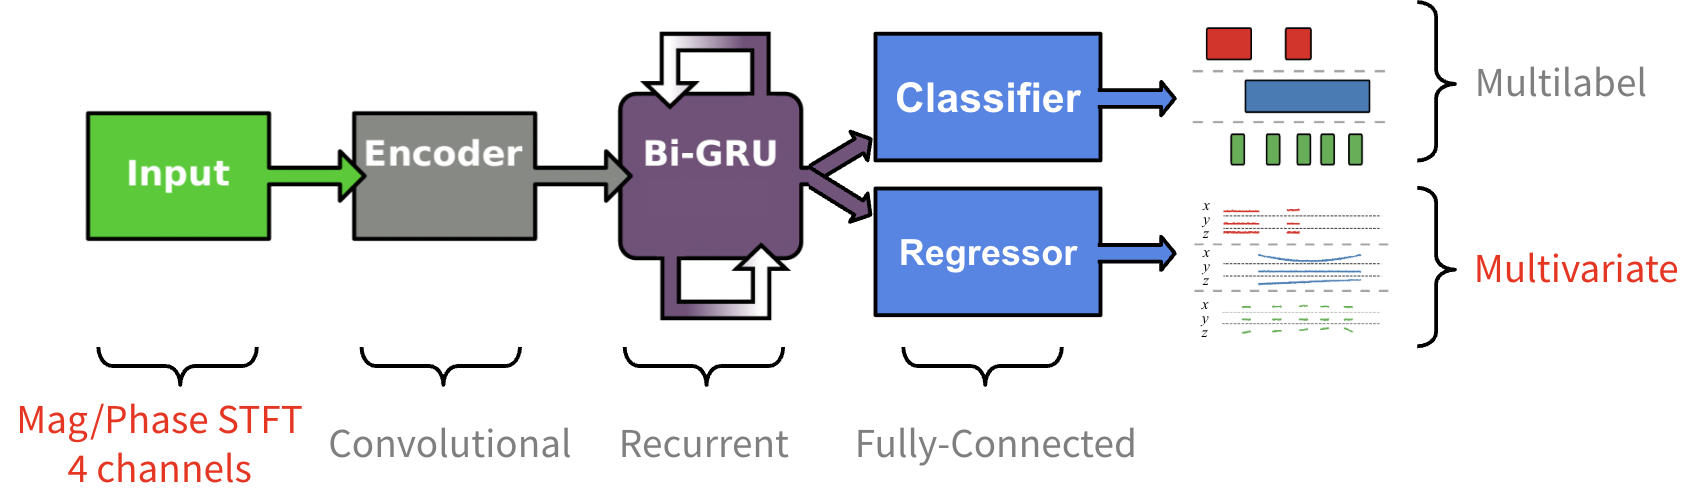



# Data
For this assignment, we will use the DCASE 2019 Task 3 dataset with a couple specifications:
- We will be using the 4-channel FOA (first-order Ambisonics) audio, not the "MIC" format.
- We will use the **development** dataset only, which has 400 1-minute recordings at 48kHz.
- There can be simultaneous sounds from different classes, but not from the same class.
- Use folds 3 and 4 for training, fold 2 for validation, and 1 for test.
- The recordings follow the following naming convention:
`split[number]_ir[location number]_ov[number of overlapping sound events]_[recording number per split].wav`.

## Getting the data
Download the DCASE FOA development dataset from Google Drive here: https://drive.google.com/drive/folders/1lTgUcnbHKO-BL2JSRXdtpI9SxaKfiOn_?usp=sharing. This contains the metadata and ambisonics audio.

Put these zip files in your Drive, then mount your drive and unzip the files running the code below.

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
!unzip "/content/drive/MyDrive/assignment4_files/metadata_dev.zip" -d "/content"

Archive:  /content/drive/MyDrive/assignment4_files/metadata_dev.zip
   creating: /content/metadata_dev/
  inflating: /content/metadata_dev/split1_ir0_ov1_1.csv  
  inflating: /content/metadata_dev/split1_ir0_ov1_10.csv  
  inflating: /content/metadata_dev/split1_ir0_ov1_2.csv  
  inflating: /content/metadata_dev/split1_ir0_ov1_3.csv  
  inflating: /content/metadata_dev/split1_ir0_ov1_4.csv  
  inflating: /content/metadata_dev/split1_ir0_ov1_5.csv  
  inflating: /content/metadata_dev/split1_ir0_ov1_6.csv  
  inflating: /content/metadata_dev/split1_ir0_ov1_7.csv  
  inflating: /content/metadata_dev/split1_ir0_ov1_8.csv  
  inflating: /content/metadata_dev/split1_ir0_ov1_9.csv  
  inflating: /content/metadata_dev/split1_ir0_ov2_11.csv  
  inflating: /content/metadata_dev/split1_ir0_ov2_12.csv  
  inflating: /content/metadata_dev/split1_ir0_ov2_13.csv  
  inflating: /content/metadata_dev/split1_ir0_ov2_14.csv  
  inflating: /content/metadata_dev/split1_ir0_ov2_15.csv  
  inflating: /conten

In [6]:
!unzip "/content/drive/MyDrive/assignment4_files/foa_dev_all_compressed.zip" -d "/content"

Archive:  /content/drive/MyDrive/assignment4_files/foa_dev_all_compressed.zip
   creating: /content/foa_dev/
  inflating: /content/__MACOSX/._foa_dev  
  inflating: /content/foa_dev/split3_ir2_ov1_42.wav  
  inflating: /content/foa_dev/split2_ir0_ov1_2.wav  
  inflating: /content/foa_dev/split3_ir1_ov2_35.wav  
  inflating: /content/__MACOSX/foa_dev/._split3_ir1_ov2_35.wav  
  inflating: /content/foa_dev/split1_ir4_ov2_95.wav  
  inflating: /content/foa_dev/split1_ir0_ov1_7.wav  
  inflating: /content/foa_dev/split4_ir1_ov2_36.wav  
  inflating: /content/foa_dev/split1_ir0_ov2_17.wav  
  inflating: /content/foa_dev/split4_ir2_ov1_41.wav  
  inflating: /content/foa_dev/split4_ir4_ov1_89.wav  
  inflating: /content/foa_dev/split2_ir2_ov1_46.wav  
  inflating: /content/foa_dev/split2_ir1_ov2_31.wav  
  inflating: /content/foa_dev/split4_ir0_ov1_8.wav  
  inflating: /content/__MACOSX/foa_dev/._split4_ir0_ov1_8.wav  
  inflating: /content/foa_dev/split3_ir3_ov2_80.wav  
  inflating: /conten

## Writing your dataloader
Design a PyTorch dataset class that extracts features from the 4-channel audio as described in class:

**Audio Features**
- Loads the 4-channel FOA waveform
- For each channel, get the magnitude and phase from the STFT if the audio. Use the parameters in the template dataloader below - I've figured this out for you so that the time bins align to 3000 to match the output desired T.
- Final feature dimension should be shape `(T x N/2 x 2K)`, where `N` is the length of your STFT window (N/2 because of positive frequencies only being used, discard 0th bin), T is the number of time frames (50 frames per second for 60 sec clip = 3000 frames per clip), and K is the number of channels (2K due to stacking K magnitude components and K phase components -> 2K = 8). TLDR: this should be of shape `(batch, 3000, 1024, 8)`.

**Labels**

Each input feature matrix should have two corresponding ground truth features:
- DOA ground truth: Overall shape here will be `(batch, T, 3C)` where x, y, and z are DOA coordinates are for each class at each time frame. Note that the metadata contains this position in elevation and azimuth instead of cartesian coordinates. We will evaluate in elevation and azimuth, but for training, use cartesian. You can convert between the two with the helper functions I've provided below.
- SED ground truth: Overall shape here will be `(batch, T, C)` where T is frame index and C is class index. This is 1 if a sound class is present in a given frame and 0 otherwise.


Other important dataloader notes:
- Your dataloader should take a data split argument, and filter the audio and metadata files to only load the corresponding splits based on the fold information above. See the example in the last assignment for help on this.
- There are 11 sound event classes. You will need to map the string from `sound_event_recording` to a class index, building off of something like this: `class_list = ['clearthroat','cough','doorslam','drawer', 'keyboard',
 'keysDrop',
 'knock',
 'laughter',
 'pageturn',
 'phone',
 'speech']`

### ❗Deliverables❗
- Data loader class
- Print the shapes of your input features and 2 sets of ground truth labels while running a sample batch iteration through your dataloader
- Plot the spectrogram of one channel of one of the audio files and also plot the corresponding SED labels. Check that these align and everything is making sense.

In [9]:
# TODO : Build your dataloader!

def next_greater_power_of_2(x): # just a helper
    return 2 ** (x - 1).bit_length()

class SELDDataset(Dataset):
    def __init__(self, csv_dir, audio_dir, data_split):
        """
        Args:
            csv_dir (str): Directory containing CSV files, one per audio clip.
            audio_dir (str): Directory containing audio files, one per audio clip.
            data_split (str): train, val, test split specification.
        """
        self.class_list = ['clearthroat','cough','doorslam','drawer', 'keyboard', 'keysDrop', 'knock', 'laughter', 'pageturn', 'phone', 'speech']
        self.class_dict = {cls: idx for idx, cls in enumerate(self.class_list)}
        self.num_classes = len(self.class_list)
        # STFT params, keep these for ease of dimensionality and time alignment
        self.sample_rate = 48000
        self.frame_hop = 0.2 # for meta
        self.hop_len = int(self.sample_rate * 0.02) # for spec
        self.win_len = 2 * self.hop_len
        self.nfft = next_greater_power_of_2(self.win_len)
        self.duration = 60
        self.T = int(self.duration / 0.02) # total number of frames

        # ! TODO : everything else in your dataloader init
        # Map data_split to fold numbers
        fold_mapping = {
            'train': [3, 4],
            'val': [2],
            'test': [1]
        }
        target_folds = fold_mapping.get(data_split, [])

        # Get all audio files that match the specified folds
        all_audio_files = glob(os.path.join(audio_dir, '*.wav'))
        self.audio_files = []
        self.csv_files = []

        for audio_file in all_audio_files:
            # Extract fold number from filename (split[number]_ir[location]_ov[overlaps]_[recording].wav)
            filename = os.path.basename(audio_file)
            fold_num = int(filename.split('_')[0].replace('split', ''))

            if fold_num in target_folds:
                audio_basename = os.path.splitext(filename)[0]
                csv_file = os.path.join(csv_dir, audio_basename + '.csv')

                if os.path.exists(csv_file):
                    self.audio_files.append(audio_file)
                    self.csv_files.append(csv_file)

        print(f"Loaded {len(self.audio_files)} files for {data_split} split (folds {target_folds})")

    def __len__(self):
        # TODO
        return len(self.audio_files)

    def _extract_audio_features(self, audio_path):
        """
        Extract magnitude and phase STFT features from 4-channel audio

        Args:
            audio_path (str): Path to the audio file

        Returns:
            torch.Tensor: Features of shape (T, N/2, 2K)
        """
        # Load the audio file
        waveform, sr = torchaudio.load(audio_path)

        # Check if the sample rate matches
        if sr != self.sample_rate:
            waveform = torchaudio.transforms.Resample(sr, self.sample_rate)(waveform)

        # Check if we have 4 channels
        assert waveform.shape[0] == 4, f"Expected 4 channels, got {waveform.shape[0]}"

        # Ensure the audio is exactly 60 seconds
        expected_samples = self.sample_rate * self.duration
        if waveform.shape[1] < expected_samples:
            # Pad if shorter
            padding = torch.zeros(4, expected_samples - waveform.shape[1])
            waveform = torch.cat([waveform, padding], dim=1)
        elif waveform.shape[1] > expected_samples:
            # Truncate if longer
            waveform = waveform[:, :expected_samples]

        # Initialize feature matrix (T, N/2, 2K) - shape matches (3000, 1024, 8)
        features = torch.zeros(self.T, self.nfft//2, 8)

        # Compute STFT for each channel
        for ch in range(4):
            # Compute STFT
            specs = torch.stft(
                waveform[ch],
                n_fft=self.nfft,
                hop_length=self.hop_len,
                win_length=self.win_len,
                window=torch.hann_window(self.win_len),
                return_complex=True
            )

            # Extract magnitude and phase
            mag = torch.abs(specs)  # Shape: (freqs, frames)
            phase = torch.angle(specs)  # Shape: (freqs, frames)

            # Transpose to get (frames, freqs) and handle frequency dimension properly
            mag = mag[:self.nfft//2, :self.T].T  # Shape: (T, N/2)
            phase = phase[:self.nfft//2, :self.T].T  # Shape: (T, N/2)

            # Store in features tensor
            features[:, :, ch] = mag  # First 4 channels: magnitude
            features[:, :, ch + 4] = phase  # Last 4 channels: phase

        return features

    def _process_metadata(self, csv_path):
        """
        Process metadata from CSV file to create DOA and SED ground truth

        Args:
            csv_path (str): Path to the CSV file

        Returns:
            tuple: (doa_matrix, sed_matrix)
                doa_matrix: torch.Tensor of shape (T, 3C) for x, y, z coordinates
                sed_matrix: torch.Tensor of shape (T, C) for class presence
        """
        # Initialize ground truth matrices
        doa_matrix = torch.zeros(self.T, 3 * self.num_classes)
        sed_matrix = torch.zeros(self.T, self.num_classes)

        # Read CSV file
        metadata = pd.read_csv(csv_path)

        # Process each sound event
        for _, row in metadata.iterrows():
            # Extract data from row
            start_time = float(row['start_time'])
            end_time = float(row['end_time'])

            # Get azimuth and elevation from 'azi' and 'ele' columns
            source_azimuth = float(row['azi'])
            source_elevation = float(row['ele'])
            event_class = row['sound_event_recording']

            # Skip if class not in our class_dict
            if event_class not in self.class_dict:
                continue

            # Convert to class index
            class_idx = self.class_dict[event_class]

            # Convert from spherical to cartesian coordinates (unit sphere, r=1)
            x, y, z = sph2cart(np.radians(source_azimuth), np.radians(source_elevation), 1.0)

            # Calculate frame indices
            start_frame = max(0, int(start_time / self.frame_hop))
            end_frame = min(self.T, int(end_time / self.frame_hop))

            # Fill in SED matrix (1 for active frames)
            sed_matrix[start_frame:end_frame, class_idx] = 1.0

            # Fill in DOA matrix for active frames
            # Each class has 3 values (x, y, z) in the DOA matrix
            doa_matrix[start_frame:end_frame, class_idx*3] = x
            doa_matrix[start_frame:end_frame, class_idx*3 + 1] = y
            doa_matrix[start_frame:end_frame, class_idx*3 + 2] = z

        return doa_matrix, sed_matrix

    def __getitem__(self, idx):
        # TODO
        # A lot of code here for compute audio features and metadata processing
        # Recommend separating this into two helper functions
        # Remember to use the sph2cart helper functions such that you are working in Cartesian

        # Get paths for current index
        audio_path = self.audio_files[idx]
        csv_path = self.csv_files[idx]

        # Extract features and labels
        spec_feats = self._extract_audio_features(audio_path)
        doa_matrix, sed_matrix = self._process_metadata(csv_path)

        return spec_feats, doa_matrix, sed_matrix


In [10]:
# Helper functions for spherical (azimuth and elevation) to cartesian (x,y,z)
def sph2cart(azimuth, elevation, r):
    '''
    Convert spherical to cartesian coordinates

    :param azimuth: in radians
    :param elevation: in radians
    :param r: in meters
    :return: cartesian coordinates
    '''

    x = r * np.cos(elevation) * np.cos(azimuth)
    y = r * np.cos(elevation) * np.sin(azimuth)
    z = r * np.sin(elevation)
    return x, y, z

def cart2sph(x, y, z):
    '''
    Convert cartesian to spherical coordinates

    :param x:
    :param y:
    :param z:
    :return: azi, ele in radians and r in meters
    '''

    azimuth = np.arctan2(y,x)
    elevation = np.arctan2(z,np.sqrt(x**2 + y**2))
    r = np.sqrt(x**2 + y**2 + z**2)
    return azimuth, elevation, r

Loaded 100 files for test split (folds [1])
Dataset size: 100
Batch 0:
  spec_feats shape: torch.Size([1, 3000, 1024, 8])
  doa_matrix shape: torch.Size([1, 3000, 33])
  sed_matrix shape: torch.Size([1, 3000, 11])


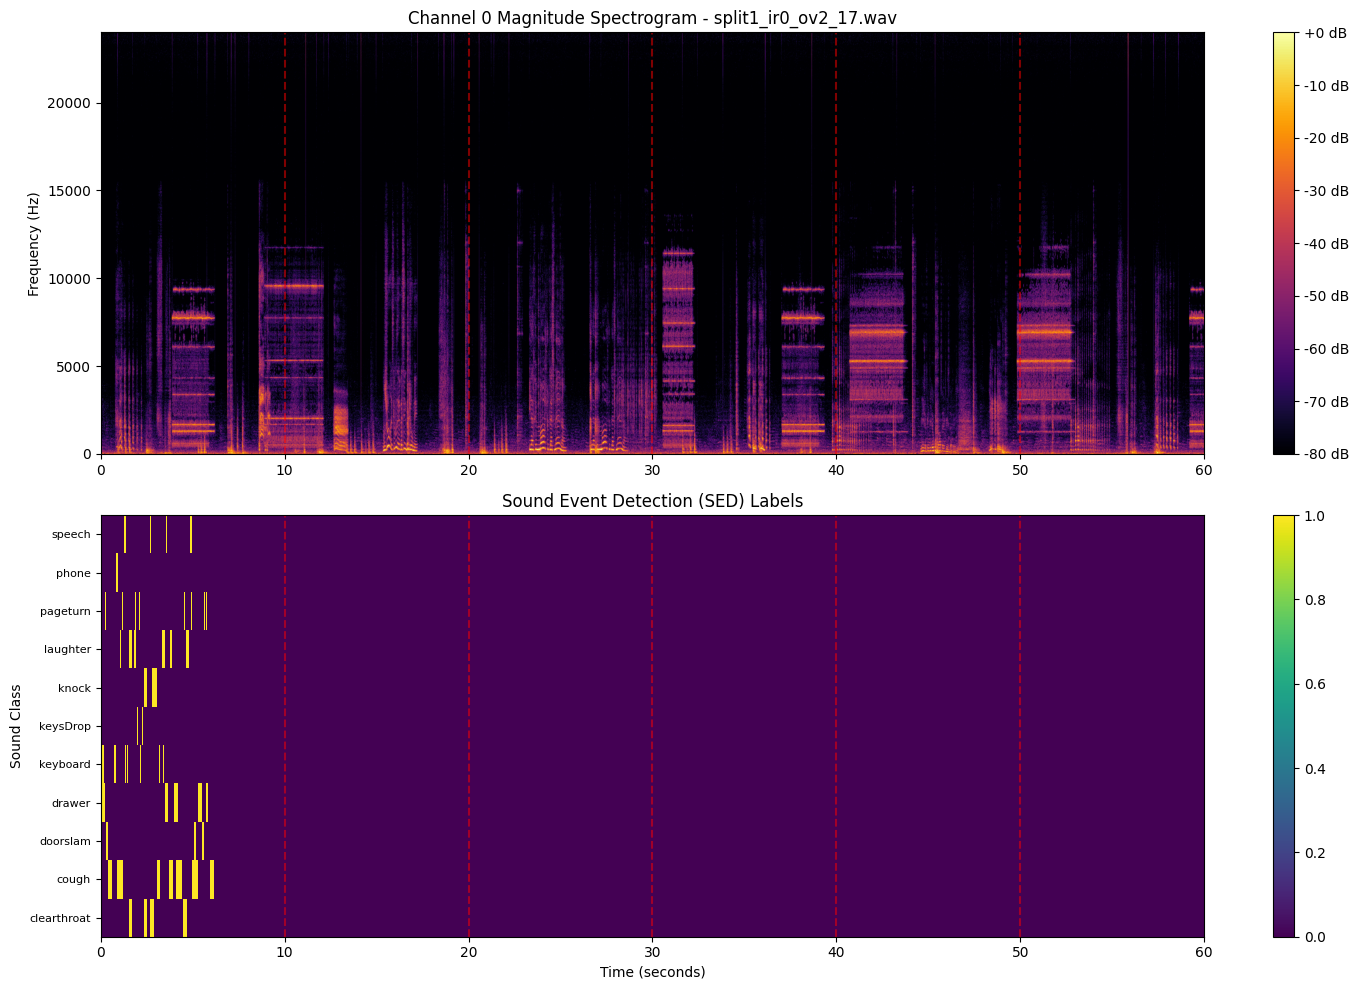


Active sound events in this sample:
  clearthroat: 1.3s - 4.9s
  cough: 0.8s - 0.9s
  doorslam: 0.2s - 5.8s
  drawer: 1.0s - 4.7s
  keyboard: 2.3s - 3.0s
  keysDrop: 2.0s - 5.4s
  knock: 0.1s - 3.4s
  laughter: 0.1s - 5.8s
  pageturn: 0.3s - 5.6s
  phone: 0.4s - 6.1s
  speech: 1.5s - 4.7s


In [11]:
# TODO
# Testing your dataloader and printing shapes of each component returned by get_item()
csv_dir = "/content/metadata_dev"
audio_dir = "/content/foa_dev/"
data_split = "test"  # Using test split for visualization

dataset = SELDDataset(csv_dir=csv_dir, audio_dir=audio_dir, data_split=data_split)
print(f"Dataset size: {len(dataset)}")
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

# Iterate through one batch and print shapes
for batch_idx, (spec_feats, doa_matrix, sed_matrix) in enumerate(dataloader):
    print(f"Batch {batch_idx}:")
    print(f"  spec_feats shape: {spec_feats.shape}")
    print(f"  doa_matrix shape: {doa_matrix.shape}")
    print(f"  sed_matrix shape: {sed_matrix.shape}")
    break

sample_idx = 0  # Index of sample to visualize
spec_feats, doa_matrix, sed_matrix = dataset[sample_idx]

# Get the filename for reference
sample_audio_file = os.path.basename(dataset.audio_files[sample_idx])

# Plot spectrogram and SED labels
plt.figure(figsize=(15, 10))

# Plot 1: Spectrogram of first channel magnitude
plt.subplot(2, 1, 1)
mag_channel_0 = spec_feats[:, :, 0]  # First channel magnitude

# Convert to dB scale for better visualization
mag_db = librosa.amplitude_to_db(mag_channel_0.numpy(), ref=np.max)

# Plot as a spectrogram image
plt.imshow(
    mag_db.T,  # Transpose for correct orientation
    aspect='auto',
    origin='lower',
    extent=[0, dataset.duration, 0, dataset.sample_rate//2],
    cmap='inferno'
)
plt.colorbar(format='%+2.0f dB')
plt.title(f'Channel 0 Magnitude Spectrogram - {sample_audio_file}')
plt.ylabel('Frequency (Hz)')

# Plot 2: SED labels
plt.subplot(2, 1, 2)
plt.imshow(
    sed_matrix.T.numpy(),  # Transpose for class on y-axis, time on x-axis
    aspect='auto',
    extent=[0, dataset.duration, -0.5, dataset.num_classes - 0.5],
    cmap='viridis',
    interpolation='nearest'
)
plt.colorbar()
plt.title('Sound Event Detection (SED) Labels')
plt.xlabel('Time (seconds)')
plt.ylabel('Sound Class')
plt.yticks(range(dataset.num_classes), dataset.class_list, fontsize=8)

# Add vertical lines to help with alignment validation
for ax in plt.gcf().axes:
    ax.axvline(x=10, color='r', linestyle='--', alpha=0.5)
    ax.axvline(x=20, color='r', linestyle='--', alpha=0.5)
    ax.axvline(x=30, color='r', linestyle='--', alpha=0.5)
    ax.axvline(x=40, color='r', linestyle='--', alpha=0.5)
    ax.axvline(x=50, color='r', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Print active sound events for this sample
print("\nActive sound events in this sample:")
for class_idx in range(dataset.num_classes):
    if torch.any(sed_matrix[:, class_idx] > 0):
        active_frames = torch.where(sed_matrix[:, class_idx] > 0)[0]
        start_time = active_frames[0].item() * 0.02
        end_time = active_frames[-1].item() * 0.02
        print(f"  {dataset.class_list[class_idx]}: {start_time:.1f}s - {end_time:.1f}s")

In [ ]:
class MiniSELDDataset(SELDDataset):
    def __init__(self, csv_dir, audio_dir, data_split, num_samples=1, seed=None):
        """
        A mini version of the SELDDataset that only loads a specified number of files.

        Args:
            csv_dir (str): Directory containing CSV files, one per audio clip.
            audio_dir (str): Directory containing audio files, one per audio clip.
            data_split (str): train, val, test split specification.
            num_samples (int): Number of samples to keep (default: 1)
            seed (int): Random seed for reproducibility
        """
        # Call the parent constructor to initialize everything
        super().__init__(csv_dir, audio_dir, data_split)

        # Set seed for reproducibility
        if seed is not None:
            random.seed(seed)

        # Shuffle the files and keep only num_samples
        if len(self.audio_files) > 0:
            indices = list(range(len(self.audio_files)))
            random.shuffle(indices)

            # Limit to num_samples or available files, whichever is smaller
            num_to_keep = min(num_samples, len(self.audio_files))
            selected_indices = indices[:num_to_keep]

            # Keep only the selected files
            self.audio_files = [self.audio_files[i] for i in selected_indices]
            self.csv_files = [self.csv_files[i] for i in selected_indices]

            print(f"MiniSELDDataset: Kept {len(self.audio_files)} files out of the original dataset")

# Building your SELD model
Using the architecture explained in class and pictured, design a SELD PyTorch model. Recall the model input and output:

- **Model input**: magnitude and phase information from the STFT of 4-channel First Order Ambisonics (FOA) audio
- **Multi-task model output**: per 20ms frame (e.g. 3000 frames per 1 min clip):
    - **SED output**: in the continuous range of [0,1] for each class. This will be thresholded >0.5 for class activity detection in evaluation. Overall shape here will be `(batch, T, C)` where T is frame index and C is class index.
    - **DOA output**: in the continuous range of [-1,1] for each axes of the sound class location. Overall shape here will be `(batch, T, 3C)` where x, y, and z DOA coordinates are predicted for each class at each time frame.

Other notes on model architecture:
- Follow the parameters shown in slide 55 (lecture 7) from class for the architecture parameters as closely as possible (e.g. P, MP, Q, R, C). Note that the STFT parameters used above (N,T) are different than what was shown in class.

### ❗Deliverables❗
- Model architecture class
- Print the architecture and number of parameters of your model


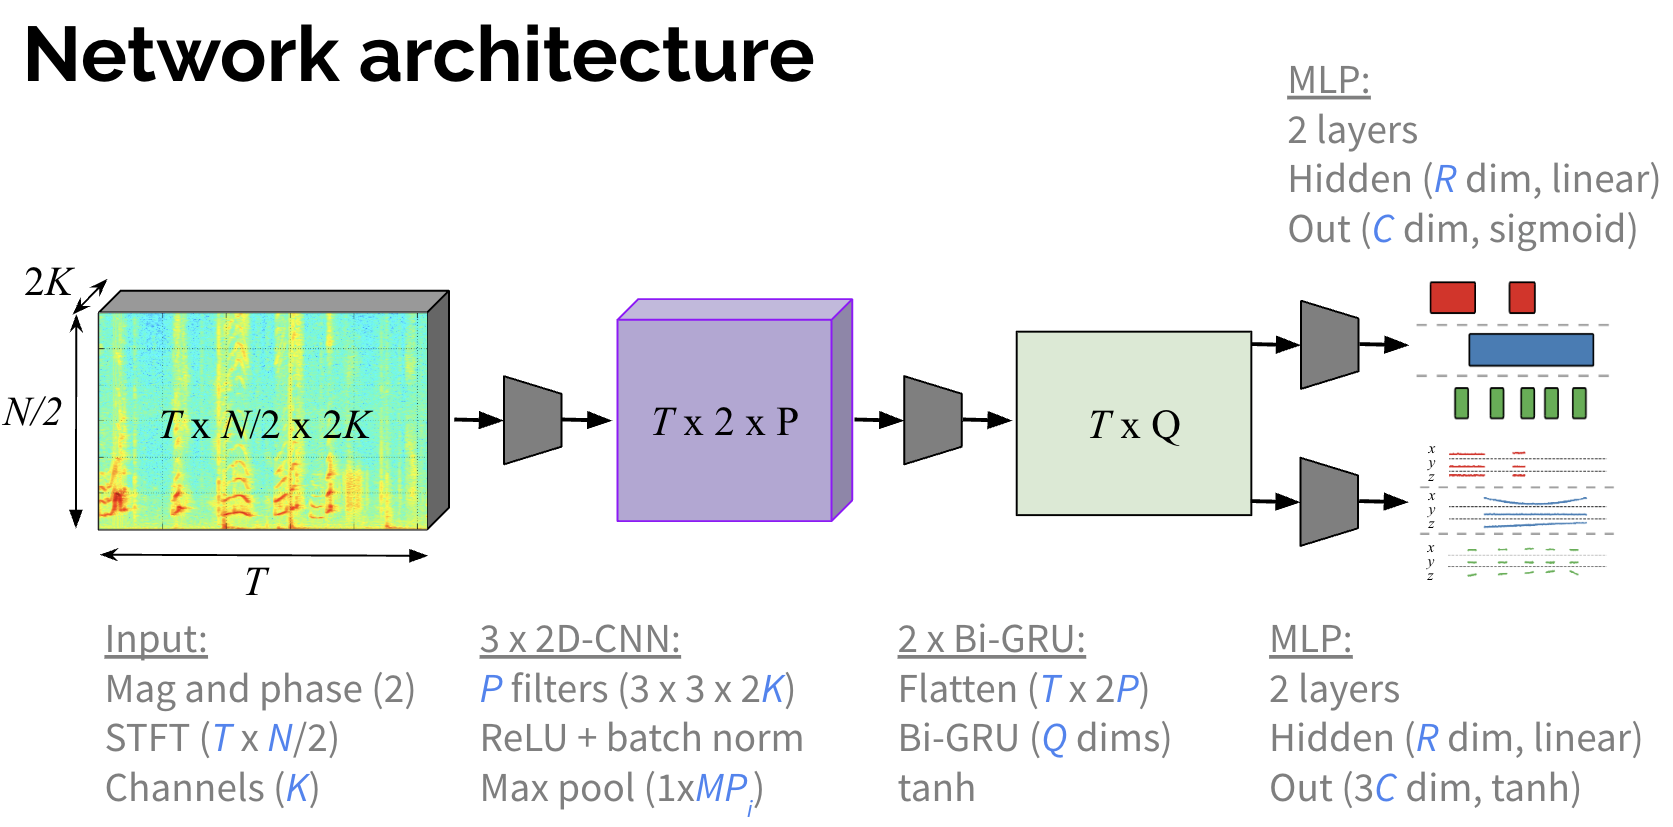

In [ ]:
class SELDModel(nn.Module):
    def __init__(self, n_classes=11, input_channels=8, P=64, MP=[8, 8, 2], Q=128, R=128, use_sigmoid=True):
        """
        Sound Event Localization and Detection (SELD) model

        Args:
            n_classes (int): Number of sound event classes
            input_channels (int): Number of input channels (2K = mag+phase for 4 channels = 8)
            P (int): Number of filters in CNN layers
            MP (list): Max pooling factors for each CNN layer
            Q (int): Number of nodes in Bi-GRU layers
            R (int): Number of nodes in MLP hidden layer
            use_sigmoid (bool): Whether to apply sigmoid to SED output (True for BCE, False for BCE with Logits)
        """
        super(SELDModel, self).__init__()
        self.n_classes = n_classes
        self.use_sigmoid = use_sigmoid

        # 3 stacked 2D-CNN layers with ReLU + batch norm + max pooling
        self.cnn1 = nn.Sequential(
            nn.Conv2d(input_channels, P, kernel_size=(3, 3), padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(P),
            nn.MaxPool2d(kernel_size=(1, MP[0]), stride=(1, MP[0]))
        )

        self.cnn2 = nn.Sequential(
            nn.Conv2d(P, P, kernel_size=(3, 3), padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(P),
            nn.MaxPool2d(kernel_size=(1, MP[1]), stride=(1, MP[1]))
        )

        self.cnn3 = nn.Sequential(
            nn.Conv2d(P, P, kernel_size=(3, 3), padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(P),
            nn.MaxPool2d(kernel_size=(1, MP[2]), stride=(1, MP[2]))
        )

        # Calculate the flattened size after the CNN layers
        # Frequency dimension reduction: 1024 -> 128 -> 16 -> 8
        self.flattened_size = P * 8  # P filters * 8 frequency bins

        # 2 x Bi-GRU with tanh activation
        self.gru = nn.GRU(self.flattened_size, Q, num_layers=2, batch_first=True,
                          bidirectional=True)

        # MLP layers
        self.fc_hidden = nn.Linear(2 * Q, R)  # 2*Q because bidirectional GRU

        # Output layers
        self.fc_sed = nn.Linear(R, n_classes)  # sigmoid activation
        self.fc_doa = nn.Linear(R, 3 * n_classes)  # tanh activation

    def forward(self, x):
        """
        Forward pass

        Args:
            x (torch.Tensor): Input features of shape (batch, T, freq_bins, channels)
                              Where T = number of time frames, freq_bins = N/2, channels = 2K

        Returns:
            tuple: (sed_output, doa_output)
                  sed_output: Sound event detection output of shape (batch, T, n_classes)
                  doa_output: Direction of arrival output of shape (batch, T, 3*n_classes)
        """
        # Input shape: (batch, T, freq_bins, channels) = (batch, 3000, 1024, 8)
        batch_size, T, freq_bins, channels = x.shape

        # Reshape to: (batch, channels, T, freq_bins) for CNN input
        x = x.permute(0, 3, 1, 2)

        # Apply CNN layers
        x = self.cnn1(x)
        x = self.cnn2(x)
        x = self.cnn3(x)

        # Reshape for GRU: (batch, T, P * reduced_freq_bins)
        x = x.permute(0, 2, 1, 3)  # (batch, T, P, reduced_freq_bins)
        x = x.reshape(batch_size, T, -1)  # (batch, T, P * reduced_freq_bins)

        # Apply GRU
        x, _ = self.gru(x)

        # Apply MLP hidden layer with linear activation
        x = self.fc_hidden(x)  # Linear activation is default

        # Apply output layers with appropriate activations
        sed_output = self.fc_sed(x)

        # Conditionally apply sigmoid based on use_sigmoid parameter
        if self.use_sigmoid:
            sed_output = torch.sigmoid(sed_output)

        doa_output = torch.tanh(self.fc_doa(x))  # DOA output: (batch, T, 3*n_classes)

        return sed_output, doa_output

In [ ]:
# TODO
# Print the model architecture and number of parameters
model = SELDModel(n_classes=11, input_channels=8, P=64, MP=[8, 8, 2], Q=128, R=128, use_sigmoid=False)
summary(model, input_size=(1, 3000, 1024, 8))

Layer (type:depth-idx)                   Output Shape              Param #
SELDModel                                [1, 3000, 11]             --
├─Sequential: 1-1                        [1, 64, 3000, 128]        --
│    └─Conv2d: 2-1                       [1, 64, 3000, 1024]       4,672
│    └─ReLU: 2-2                         [1, 64, 3000, 1024]       --
│    └─BatchNorm2d: 2-3                  [1, 64, 3000, 1024]       128
│    └─MaxPool2d: 2-4                    [1, 64, 3000, 128]        --
├─Sequential: 1-2                        [1, 64, 3000, 16]         --
│    └─Conv2d: 2-5                       [1, 64, 3000, 128]        36,928
│    └─ReLU: 2-6                         [1, 64, 3000, 128]        --
│    └─BatchNorm2d: 2-7                  [1, 64, 3000, 128]        128
│    └─MaxPool2d: 2-8                    [1, 64, 3000, 16]         --
├─Sequential: 1-3                        [1, 64, 3000, 8]          --
│    └─Conv2d: 2-9                       [1, 64, 3000, 16]         36,928
│ 

In [ ]:
# Delete model to free memory
del model
# If using GPU, also clear CUDA cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()
# Force garbage collection for better memory cleanup
gc.collect()

print("Model removed from memory")

Model removed from memory


# Training your model
Train and validate your model. Use sample code from the previous assignment for a template on training and validation scripts.

For the **loss** function, follow the loss explained in class (pictured). Note the proposed optimal weighting params were $ Β = 50*\alpha$.

Train for 100 epochs. Note that on the collab A100, with batch size 2 (for out of memory issues), one training+validation loop was taking 2 minutes for me.

### ❗Deliverables❗
- Training and validation code
- Plot the training and validation total loss curves (monitor this during training!)
- Plot the training and validation loss curves broken down by the weighted SED and SEL components.
- Save the best model based on validation loss (locally), you will need it for evaluation below.


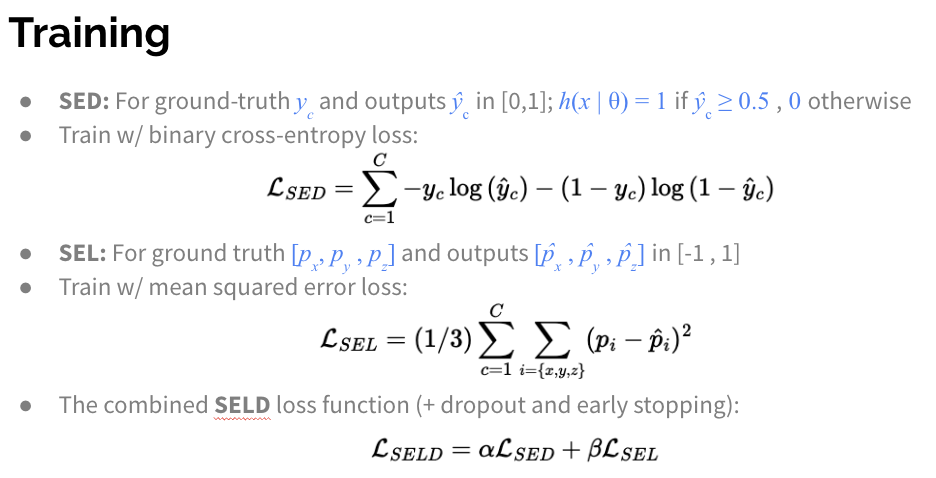

In [27]:
def train_seld_model(
    model,
    train_dataloader,
    val_dataloader,
    device,
    num_epochs=100,
    lr=0.001,
    bce_with_logits=False,
    sed_threshold=0.5,
    loss_weights=(1.0, 50.0),
    early_stopping=False,
    patience=10,
    scheduler=None,
    save_path="best_seld_model.pth"
):
    # Make sure model is on the correct device
    model = model.to(device)

    # Set up optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Set up loss functions based on bce_with_logits flag
    if bce_with_logits:
        sed_loss_fn = nn.BCEWithLogitsLoss()
        model.use_sigmoid = False  # Make sure model doesn't apply sigmoid
    else:
        sed_loss_fn = nn.BCELoss()
        model.use_sigmoid = True   # Make sure model applies sigmoid

    sel_loss_fn = nn.MSELoss()

    # Unpack loss weights
    alpha, beta = loss_weights

    # History tracking
    history = {
        'train_total_loss': [],
        'train_sed_loss': [],
        'train_sel_loss': [],
        'val_total_loss': [],
        'val_sed_loss': [],
        'val_sel_loss': []
    }

    # Early stopping variables
    best_val_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    no_improve_epochs = 0

    # Start training
    start_time = time.time()

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print('-' * 10)

        # Training phase
        model.train()
        train_total_loss = 0.0
        train_sed_loss_sum = 0.0
        train_sel_loss_sum = 0.0
        train_batches = 0

        # Training loop
        for spec_feats, doa_gt, sed_gt in tqdm(train_dataloader, desc="Training"):
            # Move data to device
            spec_feats = spec_feats.to(device)
            doa_gt = doa_gt.to(device)
            sed_gt = sed_gt.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            sed_pred, doa_pred = model(spec_feats)

            # Compute SED loss
            sed_loss = sed_loss_fn(sed_pred, sed_gt)

            # Compute SEL loss (only for active sound events)
            # Create a mask for active sound events using ground truth
            active_mask = (sed_gt > sed_threshold).float()

            # Apply mask to predictions and ground truth
            # Make sure dimensions match by checking shapes
            n_classes = sed_gt.shape[-1]

            # Fixed masking approach - reshape mask to match DOA dimensions
            # For each class, we have 3 coordinates (x, y, z)
            mask_expanded = torch.zeros_like(doa_pred)

            # Loop through classes and set the mask for each coordinate
            for i in range(n_classes):
                # For each class, set the mask for its 3 coordinates (x, y, z)
                mask_expanded[..., i*3:i*3+3] = active_mask[..., i:i+1].repeat(1, 1, 3)

            # Apply the expanded mask
            doa_pred_masked = doa_pred * mask_expanded
            doa_gt_masked = doa_gt * mask_expanded

            # Compute SEL loss
            sel_loss = sel_loss_fn(doa_pred_masked, doa_gt_masked)

            # Compute weighted total loss
            total_loss = alpha * sed_loss + beta * sel_loss

            # Backpropagation
            total_loss.backward()
            optimizer.step()

            # Update running loss
            train_total_loss += total_loss.item()
            train_sed_loss_sum += sed_loss.item()
            train_sel_loss_sum += sel_loss.item()
            train_batches += 1

        # Update learning rate if scheduler is provided
        if scheduler is not None:
            scheduler.step()

        # Calculate average training losses
        avg_train_total_loss = train_total_loss / train_batches
        avg_train_sed_loss = train_sed_loss_sum / train_batches
        avg_train_sel_loss = train_sel_loss_sum / train_batches

        # Store training losses
        history['train_total_loss'].append(avg_train_total_loss)
        history['train_sed_loss'].append(avg_train_sed_loss)
        history['train_sel_loss'].append(avg_train_sel_loss)

        # Print training losses
        print(f"Training: Total Loss: {avg_train_total_loss:.4f}, "
              f"SED Loss: {avg_train_sed_loss:.4f}, "
              f"SEL Loss: {avg_train_sel_loss:.4f}")

        # Validation phase
        model.eval()
        val_total_loss = 0.0
        val_sed_loss_sum = 0.0
        val_sel_loss_sum = 0.0
        val_batches = 0

        # Validation loop
        with torch.no_grad():
            for spec_feats, doa_gt, sed_gt in tqdm(val_dataloader, desc="Validation"):
                # Move data to device
                spec_feats = spec_feats.to(device)
                doa_gt = doa_gt.to(device)
                sed_gt = sed_gt.to(device)

                # Forward pass
                sed_pred, doa_pred = model(spec_feats)

                # Compute SED loss
                sed_loss = sed_loss_fn(sed_pred, sed_gt)

                # Compute SEL loss (only for active sound events)
                active_mask = (sed_gt > sed_threshold).float()

                # Apply the same mask approach as in training
                n_classes = sed_gt.shape[-1]
                mask_expanded = torch.zeros_like(doa_pred)

                for i in range(n_classes):
                    mask_expanded[..., i*3:i*3+3] = active_mask[..., i:i+1].repeat(1, 1, 3)

                doa_pred_masked = doa_pred * mask_expanded
                doa_gt_masked = doa_gt * mask_expanded

                sel_loss = sel_loss_fn(doa_pred_masked, doa_gt_masked)

                # Compute weighted total loss
                total_loss = alpha * sed_loss + beta * sel_loss

                # Update running loss
                val_total_loss += total_loss.item()
                val_sed_loss_sum += sed_loss.item()
                val_sel_loss_sum += sel_loss.item()
                val_batches += 1

        # Calculate average validation losses
        avg_val_total_loss = val_total_loss / val_batches
        avg_val_sed_loss = val_sed_loss_sum / val_batches
        avg_val_sel_loss = val_sel_loss_sum / val_batches

        # Store validation losses
        history['val_total_loss'].append(avg_val_total_loss)
        history['val_sed_loss'].append(avg_val_sed_loss)
        history['val_sel_loss'].append(avg_val_sel_loss)

        # Print validation losses
        print(f"Validation: Total Loss: {avg_val_total_loss:.4f}, "
              f"SED Loss: {avg_val_sed_loss:.4f}, "
              f"SEL Loss: {avg_val_sel_loss:.4f}")

        # Check if this is the best model so far
        if avg_val_total_loss < best_val_loss:
            best_val_loss = avg_val_total_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, save_path)
            print(f"New best model saved with validation loss: {best_val_loss:.4f}")
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1

        # Early stopping check
        if early_stopping and no_improve_epochs >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

    # Training complete
    time_elapsed = time.time() - start_time
    print(f"\nTraining completed in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best validation loss: {best_val_loss:.4f}")

    # Load best model weights
    model.load_state_dict(best_model_wts)

    return history, model

In [28]:
def plot_training_history(history):
    """
    Plot training and validation loss curves with three separate panels for:
    1. Total SELD Loss
    2. Sound Event Detection Loss
    3. Sound Event Localization Loss

    Args:
        history: Dictionary containing training and validation metrics
    """
    epochs = range(1, len(history['train_total_loss']) + 1)

    # Create figure with 3 subplots in a row
    plt.figure(figsize=(18, 5))

    # Plot 1: Total SELD Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['train_total_loss'], 'b-', linewidth=2, label='Training Total Loss')
    plt.plot(epochs, history['val_total_loss'], 'r-', linewidth=2, label='Validation Total Loss')
    plt.title('Total SELD Loss', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)

    # Plot 2: Sound Event Detection Loss
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['train_sed_loss'], 'b-', linewidth=2, label='Training SED Loss')
    plt.plot(epochs, history['val_sed_loss'], 'r-', linewidth=2, label='Validation SED Loss')
    plt.title('Sound Event Detection Loss', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)

    # Plot 3: Sound Event Localization Loss
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history['train_sel_loss'], 'b-', linewidth=2, label='Training SEL Loss')
    plt.plot(epochs, history['val_sel_loss'], 'r-', linewidth=2, label='Validation SEL Loss')
    plt.title('Sound Event Localization Loss', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)

    plt.tight_layout()
    plt.show()

Using device: cuda
Loaded 200 files for train split (folds [3, 4])
Loaded 100 files for val split (folds [2])
Using device: cuda

Epoch 1/30
----------


Training:   0%|          | 0/67 [00:00<?, ?it/s]

Training: Total Loss: 0.2027, SED Loss: 0.0715, SEL Loss: 0.0026


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

Validation: Total Loss: 0.1639, SED Loss: 0.0380, SEL Loss: 0.0025
New best model saved with validation loss: 0.1639

Epoch 2/30
----------


Training:   0%|          | 0/67 [00:00<?, ?it/s]

Training: Total Loss: 0.1592, SED Loss: 0.0337, SEL Loss: 0.0025


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

Validation: Total Loss: 0.1582, SED Loss: 0.0308, SEL Loss: 0.0025
New best model saved with validation loss: 0.1582

Epoch 3/30
----------


Training:   0%|          | 0/67 [00:00<?, ?it/s]

Training: Total Loss: 0.1520, SED Loss: 0.0281, SEL Loss: 0.0025


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

Validation: Total Loss: 0.1501, SED Loss: 0.0273, SEL Loss: 0.0025
New best model saved with validation loss: 0.1501

Epoch 4/30
----------


Training:   0%|          | 0/67 [00:00<?, ?it/s]

Training: Total Loss: 0.1502, SED Loss: 0.0270, SEL Loss: 0.0025


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

Validation: Total Loss: 0.1584, SED Loss: 0.0273, SEL Loss: 0.0026

Epoch 5/30
----------


Training:   0%|          | 0/67 [00:00<?, ?it/s]

Training: Total Loss: 0.1481, SED Loss: 0.0261, SEL Loss: 0.0024


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

Validation: Total Loss: 0.1567, SED Loss: 0.0317, SEL Loss: 0.0025

Epoch 6/30
----------


Training:   0%|          | 0/67 [00:00<?, ?it/s]

Training: Total Loss: 0.1468, SED Loss: 0.0264, SEL Loss: 0.0024


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

Validation: Total Loss: 0.1546, SED Loss: 0.0266, SEL Loss: 0.0026

Epoch 7/30
----------


Training:   0%|          | 0/67 [00:00<?, ?it/s]

Training: Total Loss: 0.1437, SED Loss: 0.0269, SEL Loss: 0.0023


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

Validation: Total Loss: 0.1587, SED Loss: 0.0267, SEL Loss: 0.0026

Epoch 8/30
----------


Training:   0%|          | 0/67 [00:00<?, ?it/s]

Training: Total Loss: 0.1372, SED Loss: 0.0254, SEL Loss: 0.0022


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

Validation: Total Loss: 0.1662, SED Loss: 0.0315, SEL Loss: 0.0027
Early stopping triggered after 8 epochs

Training completed in 41m 42s
Best validation loss: 0.1501


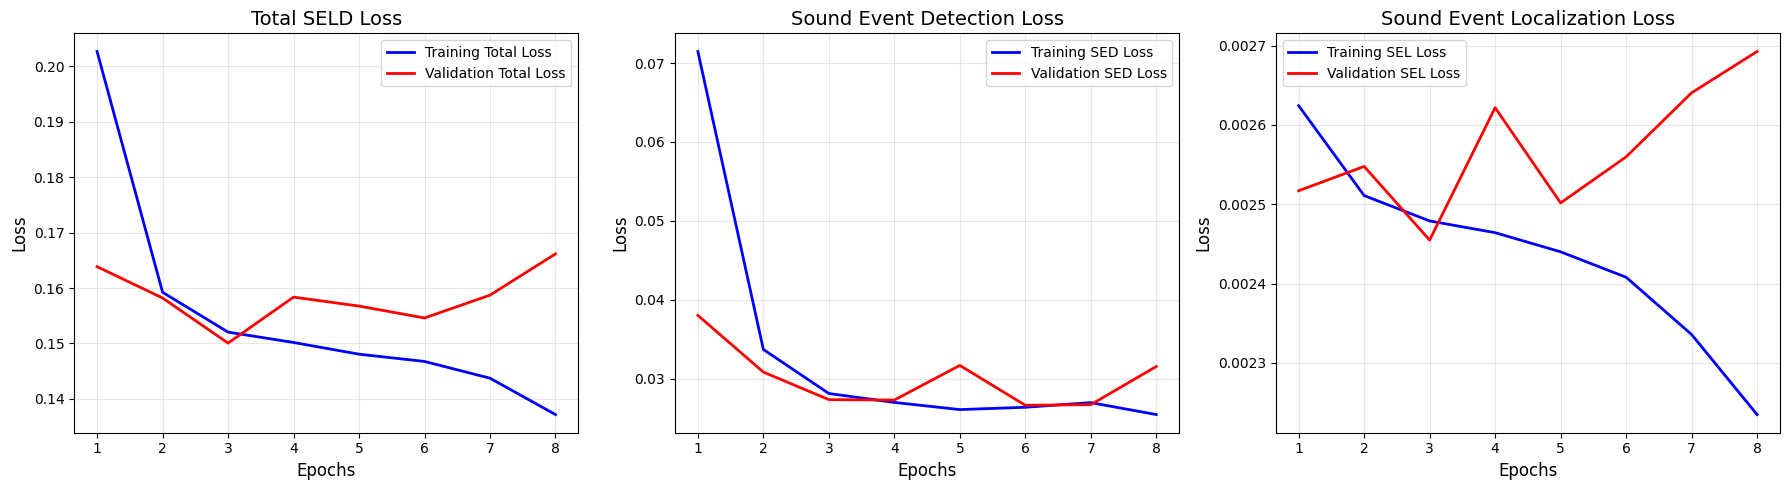

Training complete and memory freed


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create DataLoaders
csv_dir = '/content/metadata_dev'
audio_dir = '/content/foa_dev'

# Create datasets
batch_size = 3
train_dataset = SELDDataset(csv_dir=csv_dir, audio_dir=audio_dir, data_split='train')
val_dataset = SELDDataset(csv_dir=csv_dir, audio_dir=audio_dir, data_split='val')
# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize model
bce_with_logits = False
model = SELDModel(
    n_classes=11,
    input_channels=8,
    P=64,
    MP=[8, 8, 2],
    Q=128,
    R=128,
    use_sigmoid=not bce_with_logits
)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Training hyperparameters
num_epochs = 30
learning_rate = 0.001
sed_threshold = 0.3  # Threshold for SED predictions
loss_weights = (1.0, 50.0)  # Alpha and Beta weights for SED and SEL losses
use_early_stopping = True
patience = 5  # Stop after 5 epochs without improvement

# Run the training
history, trained_model = train_seld_model(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    device=device,
    num_epochs=num_epochs,
    lr=learning_rate,
    bce_with_logits=bce_with_logits,
    sed_threshold=sed_threshold,
    loss_weights=loss_weights,
    early_stopping=use_early_stopping,
    patience=patience,
    save_path="best_seld_model.pth"
)

# Plot the results
plot_training_history(history)

# Free up memory
del model
del trained_model
if torch.cuda.is_available():
    torch.cuda.empty_cache()
import gc
gc.collect()

print("Training complete and memory freed")

# Overfitting Checks

In [ ]:
csv_dir = "/content/metadata_dev"
audio_dir = "/content/foa_dev"

mini_dataset_train = MiniSELDDataset(
    csv_dir=csv_dir,
    audio_dir=audio_dir,
    data_split="train",
    num_samples=1
)

mini_dataset_val = MiniSELDDataset(
    csv_dir=csv_dir,
    audio_dir=audio_dir,
    data_split="val",
    num_samples=1
)

# Create dataloaders
train_dataloader = torch.utils.data.DataLoader(
    mini_dataset_train,
    batch_size=1,
)

val_dataloader = torch.utils.data.DataLoader(
    mini_dataset_val,
    batch_size=1,
)

Loaded 200 files for train split (folds [3, 4])
MiniSELDDataset: Kept 1 files out of the original dataset
Loaded 100 files for val split (folds [2])
MiniSELDDataset: Kept 1 files out of the original dataset


Only SEL

Using device: cuda

Epoch 1/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.1645, SED Loss: 0.6767, SEL Loss: 0.0016


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.3687, SED Loss: 0.6619, SEL Loss: 0.0037
New best model saved with validation loss: 0.3687

Epoch 2/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0854, SED Loss: 0.6798, SEL Loss: 0.0009


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.3632, SED Loss: 0.6630, SEL Loss: 0.0036
New best model saved with validation loss: 0.3632

Epoch 3/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0504, SED Loss: 0.6889, SEL Loss: 0.0005


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.3438, SED Loss: 0.6570, SEL Loss: 0.0034
New best model saved with validation loss: 0.3438

Epoch 4/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0267, SED Loss: 0.6931, SEL Loss: 0.0003


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.3309, SED Loss: 0.6561, SEL Loss: 0.0033
New best model saved with validation loss: 0.3309

Epoch 5/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0127, SED Loss: 0.6923, SEL Loss: 0.0001


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.3264, SED Loss: 0.6551, SEL Loss: 0.0033
New best model saved with validation loss: 0.3264

Epoch 6/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0074, SED Loss: 0.6891, SEL Loss: 0.0001


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.3282, SED Loss: 0.6550, SEL Loss: 0.0033

Epoch 7/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0060, SED Loss: 0.6868, SEL Loss: 0.0001


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.3309, SED Loss: 0.6557, SEL Loss: 0.0033

Epoch 8/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0047, SED Loss: 0.6850, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.3335, SED Loss: 0.6568, SEL Loss: 0.0033

Epoch 9/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0037, SED Loss: 0.6868, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.3376, SED Loss: 0.6599, SEL Loss: 0.0034

Epoch 10/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0023, SED Loss: 0.6943, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.3449, SED Loss: 0.6643, SEL Loss: 0.0034

Epoch 11/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0021, SED Loss: 0.7026, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.3537, SED Loss: 0.6667, SEL Loss: 0.0035

Epoch 12/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0017, SED Loss: 0.7048, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.3608, SED Loss: 0.6676, SEL Loss: 0.0036

Epoch 13/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0013, SED Loss: 0.7026, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.3658, SED Loss: 0.6675, SEL Loss: 0.0037

Epoch 14/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0013, SED Loss: 0.7010, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.3716, SED Loss: 0.6686, SEL Loss: 0.0037

Epoch 15/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0012, SED Loss: 0.7021, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.3791, SED Loss: 0.6717, SEL Loss: 0.0038

Epoch 16/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0010, SED Loss: 0.7047, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.3880, SED Loss: 0.6754, SEL Loss: 0.0039

Epoch 17/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0008, SED Loss: 0.7060, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.3997, SED Loss: 0.6797, SEL Loss: 0.0040

Epoch 18/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0007, SED Loss: 0.7060, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.4139, SED Loss: 0.6858, SEL Loss: 0.0041

Epoch 19/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0006, SED Loss: 0.7072, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.4270, SED Loss: 0.6908, SEL Loss: 0.0043

Epoch 20/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0005, SED Loss: 0.7084, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.4325, SED Loss: 0.6919, SEL Loss: 0.0043

Epoch 21/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0005, SED Loss: 0.7071, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.4342, SED Loss: 0.6920, SEL Loss: 0.0043

Epoch 22/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0004, SED Loss: 0.7055, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.4362, SED Loss: 0.6918, SEL Loss: 0.0044

Epoch 23/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0004, SED Loss: 0.7048, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.4386, SED Loss: 0.6940, SEL Loss: 0.0044

Epoch 24/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0004, SED Loss: 0.7058, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.4435, SED Loss: 0.6988, SEL Loss: 0.0044

Epoch 25/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0003, SED Loss: 0.7076, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.4466, SED Loss: 0.7034, SEL Loss: 0.0045

Epoch 26/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0003, SED Loss: 0.7090, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.4453, SED Loss: 0.7059, SEL Loss: 0.0045

Epoch 27/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0003, SED Loss: 0.7103, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.4451, SED Loss: 0.7067, SEL Loss: 0.0045

Epoch 28/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0002, SED Loss: 0.7111, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.4478, SED Loss: 0.7079, SEL Loss: 0.0045

Epoch 29/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0002, SED Loss: 0.7118, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.4491, SED Loss: 0.7071, SEL Loss: 0.0045

Epoch 30/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0002, SED Loss: 0.7110, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.4486, SED Loss: 0.7093, SEL Loss: 0.0045

Epoch 31/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0002, SED Loss: 0.7116, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.4509, SED Loss: 0.7091, SEL Loss: 0.0045

Epoch 32/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0003, SED Loss: 0.7116, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.4505, SED Loss: 0.7136, SEL Loss: 0.0045

Epoch 33/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0003, SED Loss: 0.7140, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.4416, SED Loss: 0.7103, SEL Loss: 0.0044

Epoch 34/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0004, SED Loss: 0.7117, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.4437, SED Loss: 0.7159, SEL Loss: 0.0044

Epoch 35/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0003, SED Loss: 0.7139, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.4486, SED Loss: 0.7196, SEL Loss: 0.0045

Epoch 36/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0002, SED Loss: 0.7149, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.4337, SED Loss: 0.7209, SEL Loss: 0.0043

Epoch 37/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0001, SED Loss: 0.7143, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.4323, SED Loss: 0.7246, SEL Loss: 0.0043

Epoch 38/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0002, SED Loss: 0.7159, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.4413, SED Loss: 0.7263, SEL Loss: 0.0044

Epoch 39/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0002, SED Loss: 0.7165, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.4279, SED Loss: 0.7260, SEL Loss: 0.0043

Epoch 40/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0001, SED Loss: 0.7156, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.4345, SED Loss: 0.7290, SEL Loss: 0.0043

Epoch 41/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0001, SED Loss: 0.7166, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.4415, SED Loss: 0.7322, SEL Loss: 0.0044

Epoch 42/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0001, SED Loss: 0.7180, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.4371, SED Loss: 0.7333, SEL Loss: 0.0044

Epoch 43/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0001, SED Loss: 0.7183, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.4385, SED Loss: 0.7315, SEL Loss: 0.0044

Epoch 44/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0001, SED Loss: 0.7178, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.4393, SED Loss: 0.7320, SEL Loss: 0.0044

Epoch 45/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0001, SED Loss: 0.7188, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.4309, SED Loss: 0.7316, SEL Loss: 0.0043

Epoch 46/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0001, SED Loss: 0.7191, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.4307, SED Loss: 0.7312, SEL Loss: 0.0043

Epoch 47/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0001, SED Loss: 0.7191, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.4358, SED Loss: 0.7336, SEL Loss: 0.0044

Epoch 48/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0000, SED Loss: 0.7204, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.4366, SED Loss: 0.7338, SEL Loss: 0.0044

Epoch 49/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0000, SED Loss: 0.7202, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.4314, SED Loss: 0.7324, SEL Loss: 0.0043

Epoch 50/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0001, SED Loss: 0.7199, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.4294, SED Loss: 0.7325, SEL Loss: 0.0043

Training completed in 1m 50s
Best validation loss: 0.3264


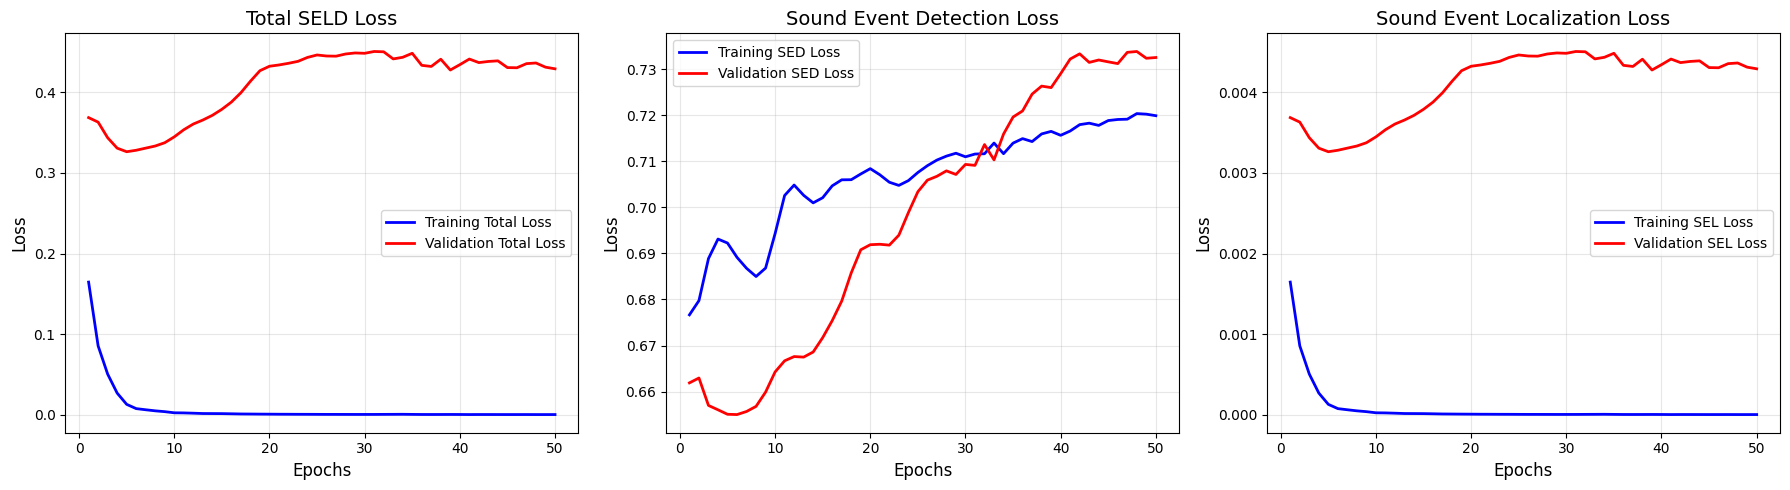

Training complete and memory freed


In [ ]:
# Initialize model
bce_with_logits = True
model = SELDModel(
    n_classes=11,
    input_channels=8,
    P=64,
    MP=[8, 8, 2],
    Q=128,
    R=128,
    use_sigmoid=not bce_with_logits

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Training hyperparameters
num_epochs = 50  # Reduced for mini dataset
learning_rate = 0.001
sed_threshold = 0.3  # Threshold for SED predictions
loss_weights = (0.0, 100.0)  # Alpha and Beta weights for SED and SEL losses
use_early_stopping = False
patience = float('inf')
# Run the training
history, trained_model = train_seld_model(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    device=device,
    num_epochs=num_epochs,
    lr=learning_rate,
    bce_with_logits=bce_with_logits,
    sed_threshold=sed_threshold,
    loss_weights=loss_weights,
    early_stopping=use_early_stopping,
    patience=patience,
    save_path="best_seld_model_mini_only_sel.pth"
)

# Plot the results
plot_training_history(history)

# Free up memory
del model
del trained_model
if torch.cuda.is_available():
    torch.cuda.empty_cache()
import gc
gc.collect()

print("Training complete and memory freed")

Only SED

Using device: cuda

Epoch 1/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.7312, SED Loss: 0.7312, SEL Loss: 0.0016


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.6196, SED Loss: 0.6196, SEL Loss: 0.0035
New best model saved with validation loss: 0.6196

Epoch 2/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.5977, SED Loss: 0.5977, SEL Loss: 0.0018


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.4547, SED Loss: 0.4547, SEL Loss: 0.0040
New best model saved with validation loss: 0.4547

Epoch 3/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.4525, SED Loss: 0.4525, SEL Loss: 0.0020


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.2997, SED Loss: 0.2997, SEL Loss: 0.0046
New best model saved with validation loss: 0.2997

Epoch 4/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.3213, SED Loss: 0.3213, SEL Loss: 0.0023


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.2000, SED Loss: 0.2000, SEL Loss: 0.0051
New best model saved with validation loss: 0.2000

Epoch 5/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.2191, SED Loss: 0.2191, SEL Loss: 0.0027


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.1389, SED Loss: 0.1389, SEL Loss: 0.0057
New best model saved with validation loss: 0.1389

Epoch 6/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.1401, SED Loss: 0.1401, SEL Loss: 0.0030


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.0983, SED Loss: 0.0983, SEL Loss: 0.0062
New best model saved with validation loss: 0.0983

Epoch 7/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0876, SED Loss: 0.0876, SEL Loss: 0.0032


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.0744, SED Loss: 0.0744, SEL Loss: 0.0067
New best model saved with validation loss: 0.0744

Epoch 8/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0581, SED Loss: 0.0581, SEL Loss: 0.0035


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.0617, SED Loss: 0.0617, SEL Loss: 0.0071
New best model saved with validation loss: 0.0617

Epoch 9/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0428, SED Loss: 0.0428, SEL Loss: 0.0037


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.0563, SED Loss: 0.0563, SEL Loss: 0.0075
New best model saved with validation loss: 0.0563

Epoch 10/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0354, SED Loss: 0.0354, SEL Loss: 0.0038


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.0552, SED Loss: 0.0552, SEL Loss: 0.0078
New best model saved with validation loss: 0.0552

Epoch 11/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0323, SED Loss: 0.0323, SEL Loss: 0.0040


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.0563, SED Loss: 0.0563, SEL Loss: 0.0080

Epoch 12/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0314, SED Loss: 0.0314, SEL Loss: 0.0041


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.0585, SED Loss: 0.0585, SEL Loss: 0.0082

Epoch 13/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0317, SED Loss: 0.0317, SEL Loss: 0.0042


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.0609, SED Loss: 0.0609, SEL Loss: 0.0084

Epoch 14/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0324, SED Loss: 0.0324, SEL Loss: 0.0043


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.0634, SED Loss: 0.0634, SEL Loss: 0.0085

Epoch 15/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0332, SED Loss: 0.0332, SEL Loss: 0.0044


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.0657, SED Loss: 0.0657, SEL Loss: 0.0086

Epoch 16/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0341, SED Loss: 0.0341, SEL Loss: 0.0045


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.0676, SED Loss: 0.0676, SEL Loss: 0.0087

Epoch 17/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0348, SED Loss: 0.0348, SEL Loss: 0.0045


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.0692, SED Loss: 0.0692, SEL Loss: 0.0088

Epoch 18/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0353, SED Loss: 0.0353, SEL Loss: 0.0046


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.0703, SED Loss: 0.0703, SEL Loss: 0.0089

Epoch 19/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0356, SED Loss: 0.0356, SEL Loss: 0.0047


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.0710, SED Loss: 0.0710, SEL Loss: 0.0090

Epoch 20/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0358, SED Loss: 0.0358, SEL Loss: 0.0048


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.0713, SED Loss: 0.0713, SEL Loss: 0.0090

Epoch 21/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0357, SED Loss: 0.0357, SEL Loss: 0.0048


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.0712, SED Loss: 0.0712, SEL Loss: 0.0090

Epoch 22/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0354, SED Loss: 0.0354, SEL Loss: 0.0049


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.0707, SED Loss: 0.0707, SEL Loss: 0.0091

Epoch 23/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0350, SED Loss: 0.0350, SEL Loss: 0.0049


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.0698, SED Loss: 0.0698, SEL Loss: 0.0091

Epoch 24/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0345, SED Loss: 0.0345, SEL Loss: 0.0050


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.0688, SED Loss: 0.0688, SEL Loss: 0.0091

Epoch 25/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0340, SED Loss: 0.0340, SEL Loss: 0.0050


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.0676, SED Loss: 0.0676, SEL Loss: 0.0091

Epoch 26/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0334, SED Loss: 0.0334, SEL Loss: 0.0051


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.0664, SED Loss: 0.0664, SEL Loss: 0.0091

Epoch 27/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0330, SED Loss: 0.0330, SEL Loss: 0.0051


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.0652, SED Loss: 0.0652, SEL Loss: 0.0090

Epoch 28/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0325, SED Loss: 0.0325, SEL Loss: 0.0052


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.0640, SED Loss: 0.0640, SEL Loss: 0.0090

Epoch 29/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0321, SED Loss: 0.0321, SEL Loss: 0.0052


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.0628, SED Loss: 0.0628, SEL Loss: 0.0089

Epoch 30/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0317, SED Loss: 0.0317, SEL Loss: 0.0052


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.0615, SED Loss: 0.0615, SEL Loss: 0.0089

Epoch 31/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0311, SED Loss: 0.0311, SEL Loss: 0.0052


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.0601, SED Loss: 0.0601, SEL Loss: 0.0088

Epoch 32/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0303, SED Loss: 0.0303, SEL Loss: 0.0052


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.0588, SED Loss: 0.0588, SEL Loss: 0.0087

Epoch 33/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0296, SED Loss: 0.0296, SEL Loss: 0.0052


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.0576, SED Loss: 0.0576, SEL Loss: 0.0086

Epoch 34/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0290, SED Loss: 0.0290, SEL Loss: 0.0051


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.0567, SED Loss: 0.0567, SEL Loss: 0.0086

Epoch 35/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0285, SED Loss: 0.0285, SEL Loss: 0.0051


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.0559, SED Loss: 0.0559, SEL Loss: 0.0085

Epoch 36/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0281, SED Loss: 0.0281, SEL Loss: 0.0051


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.0551, SED Loss: 0.0551, SEL Loss: 0.0085
New best model saved with validation loss: 0.0551

Epoch 37/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0278, SED Loss: 0.0278, SEL Loss: 0.0051


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.0543, SED Loss: 0.0543, SEL Loss: 0.0084
New best model saved with validation loss: 0.0543

Epoch 38/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0275, SED Loss: 0.0275, SEL Loss: 0.0050


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.0535, SED Loss: 0.0535, SEL Loss: 0.0084
New best model saved with validation loss: 0.0535

Epoch 39/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0271, SED Loss: 0.0271, SEL Loss: 0.0050


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.0527, SED Loss: 0.0527, SEL Loss: 0.0084
New best model saved with validation loss: 0.0527

Epoch 40/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0268, SED Loss: 0.0268, SEL Loss: 0.0050


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.0519, SED Loss: 0.0519, SEL Loss: 0.0084
New best model saved with validation loss: 0.0519

Epoch 41/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0264, SED Loss: 0.0264, SEL Loss: 0.0050


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.0510, SED Loss: 0.0510, SEL Loss: 0.0084
New best model saved with validation loss: 0.0510

Epoch 42/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0260, SED Loss: 0.0260, SEL Loss: 0.0049


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.0502, SED Loss: 0.0502, SEL Loss: 0.0084
New best model saved with validation loss: 0.0502

Epoch 43/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0257, SED Loss: 0.0257, SEL Loss: 0.0049


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.0494, SED Loss: 0.0494, SEL Loss: 0.0084
New best model saved with validation loss: 0.0494

Epoch 44/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0253, SED Loss: 0.0253, SEL Loss: 0.0049


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.0486, SED Loss: 0.0486, SEL Loss: 0.0084
New best model saved with validation loss: 0.0486

Epoch 45/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0250, SED Loss: 0.0250, SEL Loss: 0.0049


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.0478, SED Loss: 0.0478, SEL Loss: 0.0084
New best model saved with validation loss: 0.0478

Epoch 46/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0246, SED Loss: 0.0246, SEL Loss: 0.0048


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.0471, SED Loss: 0.0471, SEL Loss: 0.0084
New best model saved with validation loss: 0.0471

Epoch 47/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0243, SED Loss: 0.0243, SEL Loss: 0.0048


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.0464, SED Loss: 0.0464, SEL Loss: 0.0083
New best model saved with validation loss: 0.0464

Epoch 48/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0240, SED Loss: 0.0240, SEL Loss: 0.0048


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.0458, SED Loss: 0.0458, SEL Loss: 0.0083
New best model saved with validation loss: 0.0458

Epoch 49/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0238, SED Loss: 0.0238, SEL Loss: 0.0048


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.0453, SED Loss: 0.0453, SEL Loss: 0.0083
New best model saved with validation loss: 0.0453

Epoch 50/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0235, SED Loss: 0.0235, SEL Loss: 0.0048


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.0448, SED Loss: 0.0448, SEL Loss: 0.0082
New best model saved with validation loss: 0.0448

Training completed in 1m 39s
Best validation loss: 0.0448


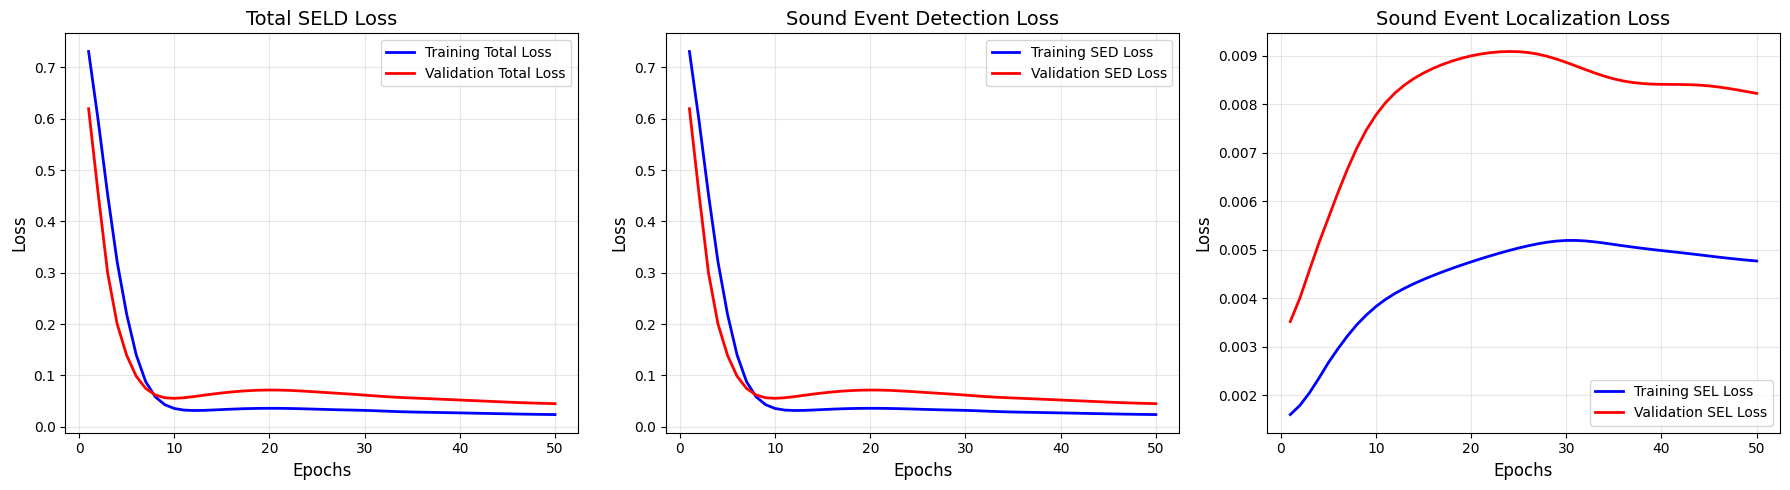

Training complete and memory freed


In [ ]:
# Initialize model
bce_with_logits = True
model = SELDModel(
    n_classes=11,
    input_channels=8,
    P=64,
    MP=[8, 8, 2],
    Q=128,
    R=128,
    use_sigmoid=not bce_with_logits
)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Training hyperparameters
num_epochs = 50  # Reduced for mini dataset
learning_rate = 0.001
sed_threshold = 0.3  # Threshold for SED predictions
loss_weights = (1.0, 0.0)  # Alpha and Beta weights for SED and SEL losses
use_early_stopping = False
patience = float('inf')

# Run the training
history, trained_model = train_seld_model(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    device=device,
    num_epochs=num_epochs,
    lr=learning_rate,
    bce_with_logits=bce_with_logits,
    sed_threshold=sed_threshold,
    loss_weights=loss_weights,
    early_stopping=use_early_stopping,
    patience=patience,
    save_path="best_seld_model_mini_only_sed.pth"
)

# Plot the results
plot_training_history(history)

# Free up memory
del model
del trained_model
if torch.cuda.is_available():
    torch.cuda.empty_cache()
import gc
gc.collect()

print("Training complete and memory freed")

Both

Using device: cuda

Epoch 1/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.7907, SED Loss: 0.7026, SEL Loss: 0.0018


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.7502, SED Loss: 0.5881, SEL Loss: 0.0032
New best model saved with validation loss: 0.7502

Epoch 2/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.6177, SED Loss: 0.5565, SEL Loss: 0.0012


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.6045, SED Loss: 0.4360, SEL Loss: 0.0034
New best model saved with validation loss: 0.6045

Epoch 3/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.4618, SED Loss: 0.4092, SEL Loss: 0.0011


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.4811, SED Loss: 0.2983, SEL Loss: 0.0037
New best model saved with validation loss: 0.4811

Epoch 4/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.3358, SED Loss: 0.2839, SEL Loss: 0.0010


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.4084, SED Loss: 0.2092, SEL Loss: 0.0040
New best model saved with validation loss: 0.4084

Epoch 5/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.2369, SED Loss: 0.1866, SEL Loss: 0.0010


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.3612, SED Loss: 0.1450, SEL Loss: 0.0043
New best model saved with validation loss: 0.3612

Epoch 6/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.1669, SED Loss: 0.1177, SEL Loss: 0.0010


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.3322, SED Loss: 0.1029, SEL Loss: 0.0046
New best model saved with validation loss: 0.3322

Epoch 7/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.1245, SED Loss: 0.0756, SEL Loss: 0.0010


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.3141, SED Loss: 0.0771, SEL Loss: 0.0047
New best model saved with validation loss: 0.3141

Epoch 8/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0998, SED Loss: 0.0520, SEL Loss: 0.0010


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.3013, SED Loss: 0.0636, SEL Loss: 0.0048
New best model saved with validation loss: 0.3013

Epoch 9/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0866, SED Loss: 0.0400, SEL Loss: 0.0009


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.2906, SED Loss: 0.0579, SEL Loss: 0.0047
New best model saved with validation loss: 0.2906

Epoch 10/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0794, SED Loss: 0.0343, SEL Loss: 0.0009


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.2821, SED Loss: 0.0563, SEL Loss: 0.0045
New best model saved with validation loss: 0.2821

Epoch 11/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0739, SED Loss: 0.0319, SEL Loss: 0.0008


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.2761, SED Loss: 0.0565, SEL Loss: 0.0044
New best model saved with validation loss: 0.2761

Epoch 12/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0703, SED Loss: 0.0314, SEL Loss: 0.0008


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.2744, SED Loss: 0.0584, SEL Loss: 0.0043
New best model saved with validation loss: 0.2744

Epoch 13/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0681, SED Loss: 0.0316, SEL Loss: 0.0007


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.2784, SED Loss: 0.0670, SEL Loss: 0.0042

Epoch 14/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0670, SED Loss: 0.0322, SEL Loss: 0.0007


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.3406, SED Loss: 0.1429, SEL Loss: 0.0040

Epoch 15/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0656, SED Loss: 0.0328, SEL Loss: 0.0007


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.8902, SED Loss: 0.7092, SEL Loss: 0.0036

Epoch 16/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0631, SED Loss: 0.0334, SEL Loss: 0.0006


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 2.7137, SED Loss: 2.5085, SEL Loss: 0.0041

Epoch 17/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0595, SED Loss: 0.0339, SEL Loss: 0.0005


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 4.0580, SED Loss: 3.8249, SEL Loss: 0.0047

Epoch 18/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0565, SED Loss: 0.0341, SEL Loss: 0.0004


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 4.6765, SED Loss: 4.4320, SEL Loss: 0.0049

Epoch 19/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0545, SED Loss: 0.0342, SEL Loss: 0.0004


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 4.8445, SED Loss: 4.5989, SEL Loss: 0.0049

Epoch 20/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0527, SED Loss: 0.0341, SEL Loss: 0.0004


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 4.8842, SED Loss: 4.6404, SEL Loss: 0.0049

Epoch 21/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0498, SED Loss: 0.0337, SEL Loss: 0.0003


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 4.6982, SED Loss: 4.4596, SEL Loss: 0.0048

Epoch 22/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0461, SED Loss: 0.0326, SEL Loss: 0.0003


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 4.6337, SED Loss: 4.3946, SEL Loss: 0.0048

Epoch 23/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0448, SED Loss: 0.0324, SEL Loss: 0.0002


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 4.6398, SED Loss: 4.3913, SEL Loss: 0.0050

Epoch 24/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0434, SED Loss: 0.0323, SEL Loss: 0.0002


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 3.8769, SED Loss: 3.6375, SEL Loss: 0.0048

Epoch 25/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0419, SED Loss: 0.0323, SEL Loss: 0.0002


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 2.7012, SED Loss: 2.4767, SEL Loss: 0.0045

Epoch 26/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0392, SED Loss: 0.0317, SEL Loss: 0.0001


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 1.3569, SED Loss: 1.1300, SEL Loss: 0.0045

Epoch 27/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0371, SED Loss: 0.0309, SEL Loss: 0.0001


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.7197, SED Loss: 0.4951, SEL Loss: 0.0045

Epoch 28/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0356, SED Loss: 0.0300, SEL Loss: 0.0001


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.6839, SED Loss: 0.4587, SEL Loss: 0.0045

Epoch 29/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0343, SED Loss: 0.0291, SEL Loss: 0.0001


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 1.0633, SED Loss: 0.8351, SEL Loss: 0.0046

Epoch 30/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0333, SED Loss: 0.0287, SEL Loss: 0.0001


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 1.8176, SED Loss: 1.5874, SEL Loss: 0.0046

Epoch 31/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0320, SED Loss: 0.0285, SEL Loss: 0.0001


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 2.2282, SED Loss: 1.9974, SEL Loss: 0.0046

Epoch 32/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0310, SED Loss: 0.0281, SEL Loss: 0.0001


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 2.2460, SED Loss: 2.0137, SEL Loss: 0.0046

Epoch 33/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0299, SED Loss: 0.0276, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 2.2650, SED Loss: 2.0302, SEL Loss: 0.0047

Epoch 34/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0296, SED Loss: 0.0274, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 2.9248, SED Loss: 2.6847, SEL Loss: 0.0048

Epoch 35/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0291, SED Loss: 0.0271, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 3.2758, SED Loss: 3.0232, SEL Loss: 0.0051

Epoch 36/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0287, SED Loss: 0.0268, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 2.8935, SED Loss: 2.6453, SEL Loss: 0.0050

Epoch 37/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0282, SED Loss: 0.0265, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 2.2410, SED Loss: 1.9953, SEL Loss: 0.0049

Epoch 38/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0276, SED Loss: 0.0261, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 1.5711, SED Loss: 1.3268, SEL Loss: 0.0049

Epoch 39/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0271, SED Loss: 0.0257, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 1.1354, SED Loss: 0.8925, SEL Loss: 0.0049

Epoch 40/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0264, SED Loss: 0.0251, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.6489, SED Loss: 0.4142, SEL Loss: 0.0047

Epoch 41/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0259, SED Loss: 0.0246, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.3719, SED Loss: 0.1398, SEL Loss: 0.0046

Epoch 42/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0253, SED Loss: 0.0240, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.3144, SED Loss: 0.0736, SEL Loss: 0.0048

Epoch 43/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0246, SED Loss: 0.0234, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.3092, SED Loss: 0.0612, SEL Loss: 0.0050

Epoch 44/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0240, SED Loss: 0.0228, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.3134, SED Loss: 0.0574, SEL Loss: 0.0051

Epoch 45/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0234, SED Loss: 0.0223, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.3204, SED Loss: 0.0572, SEL Loss: 0.0053

Epoch 46/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0228, SED Loss: 0.0218, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.3286, SED Loss: 0.0580, SEL Loss: 0.0054

Epoch 47/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0224, SED Loss: 0.0213, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.3380, SED Loss: 0.0598, SEL Loss: 0.0056

Epoch 48/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0220, SED Loss: 0.0210, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.3386, SED Loss: 0.0590, SEL Loss: 0.0056

Epoch 49/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0216, SED Loss: 0.0206, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.3479, SED Loss: 0.0611, SEL Loss: 0.0057

Epoch 50/50
----------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Training: Total Loss: 0.0215, SED Loss: 0.0204, SEL Loss: 0.0000


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: Total Loss: 0.3423, SED Loss: 0.0587, SEL Loss: 0.0057

Training completed in 1m 36s
Best validation loss: 0.2744


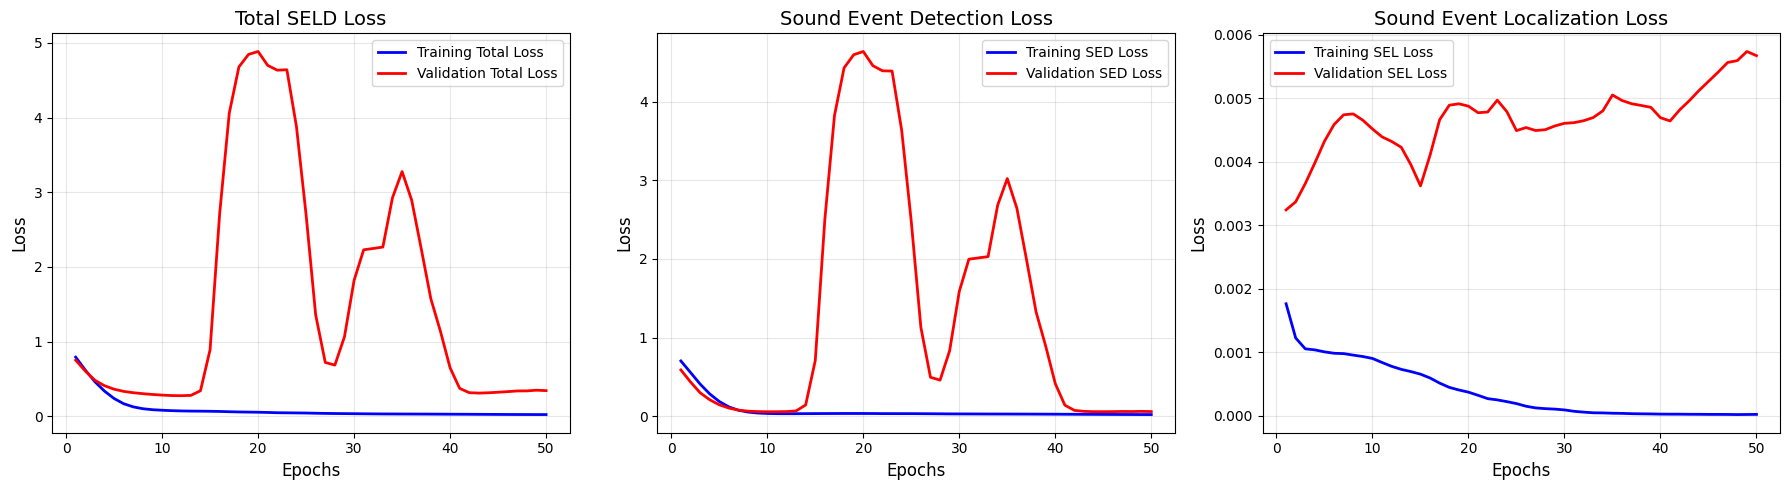

Training complete and memory freed


In [ ]:
# Initialize model
bce_with_logits = True
model = SELDModel(
    n_classes=11,
    input_channels=8,
    P=64,
    MP=[8, 8, 2],
    Q=128,
    R=128,
    use_sigmoid=not bce_with_logits
)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Training hyperparameters
num_epochs = 50  # Reduced for mini dataset
learning_rate = 0.001
sed_threshold = 0.3  # Threshold for SED predictions
loss_weights = (1.0, 50.0)  # Alpha and Beta weights for SED and SEL losses
use_early_stopping = False
patience = float('inf')
# Run the training
history, trained_model = train_seld_model(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    device=device,
    num_epochs=num_epochs,
    lr=learning_rate,
    bce_with_logits=bce_with_logits,
    sed_threshold=sed_threshold,
    loss_weights=loss_weights,
    early_stopping=use_early_stopping,
    patience=patience,
    save_path="best_seld_model_mini_both.pth"
)

# Plot the results
plot_training_history(history)

# Free up memory
del model
del trained_model
if torch.cuda.is_available():
    torch.cuda.empty_cache()
import gc
gc.collect()

print("Training complete and memory freed")

In [ ]:
# If you are getting OOM run these lines
import gc
gc.collect()
torch.cuda.empty_cache()

# Evaluating your model
Below I have included an implementation of the DCASE evaluation metrics. You can find the definition of the metrics in the class slides (66+67 from lecture 7), and also on the DCASE evaluation page [here](https://dcase.community/challenge2019/task-sound-event-localization-and-detection#evaluation).

### ❗Deliverables❗
- Load your best performing model in terms of validation loss
- Run the evaluation metrics script below on your test data split and print each of the metrics
- Below is the performance on the 4 metrics from the DCASE baseline system approximately. While it is not necessarily expected that you reproduce this or come close, it should give you a ballpark of moderate success here. Intuitively, error rate at worst = 1 and best = 0, F-score at worse = 0 and best = 1, DOA error at best is 0 degrees, and frame recall at best is 1 and worst 0.
- Comment briefly on your model performance and how it compares to this rough baseline.

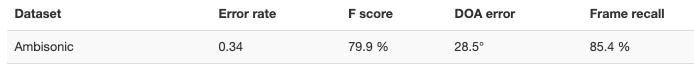



In [ ]:
# Just run this code below
from scipy.optimize import linear_sum_assignment
import numpy as np
eps = np.finfo(float).eps

def reshape_3Dto2D(A):
    return A.reshape(A.shape[0] * A.shape[1], A.shape[2])

def f1_overall_framewise(O, T):
    if len(O.shape) == 3:
        O, T = reshape_3Dto2D(O), reshape_3Dto2D(T)
    TP = ((2 * T - O) == 1).sum()
    Nref, Nsys = T.sum(), O.sum()

    prec = float(TP) / float(Nsys + eps)
    recall = float(TP) / float(Nref + eps)
    f1_score = 2 * prec * recall / (prec + recall + eps)
    return f1_score

def er_overall_framewise(O, T):
    if len(O.shape) == 3:
        O, T = reshape_3Dto2D(O), reshape_3Dto2D(T)

    FP = np.logical_and(T == 0, O == 1).sum(1)
    FN = np.logical_and(T == 1, O == 0).sum(1)

    S = np.minimum(FP, FN).sum()
    D = np.maximum(0, FN-FP).sum()
    I = np.maximum(0, FP-FN).sum()

    Nref = T.sum()
    ER = (S+D+I) / (Nref + 0.0)
    return ER


def f1_overall_1sec(O, T, block_size):
    if len(O.shape) == 3:
        O, T = reshape_3Dto2D(O), reshape_3Dto2D(T)
    new_size = int(np.ceil(float(O.shape[0]) / block_size))
    O_block = np.zeros((new_size, O.shape[1]))
    T_block = np.zeros((new_size, O.shape[1]))
    for i in range(0, new_size):
        O_block[i, :] = np.max(O[int(i * block_size):int(i * block_size + block_size - 1), :], axis=0)
        T_block[i, :] = np.max(T[int(i * block_size):int(i * block_size + block_size - 1), :], axis=0)
    return f1_overall_framewise(O_block, T_block)


def er_overall_1sec(O, T, block_size):
    if len(O.shape) == 3:
        O, T = reshape_3Dto2D(O), reshape_3Dto2D(T)
    new_size = int(np.ceil(float(O.shape[0]) / block_size))
    O_block = np.zeros((new_size, O.shape[1]))
    T_block = np.zeros((new_size, O.shape[1]))
    for i in range(0, new_size):
        O_block[i, :] = np.max(O[int(i * block_size):int(i * block_size + block_size - 1), :], axis=0)
        T_block[i, :] = np.max(T[int(i * block_size):int(i * block_size + block_size - 1), :], axis=0)
    return er_overall_framewise(O_block, T_block)

def distance_between_spherical_coordinates_rad(az1, ele1, az2, ele2):
    """
    Angular distance between two spherical coordinates
    MORE: https://en.wikipedia.org/wiki/Great-circle_distance

    :return: angular distance in degrees
    """
    dist = np.sin(ele1) * np.sin(ele2) + np.cos(ele1) * np.cos(ele2) * np.cos(np.abs(az1 - az2))
    # Making sure the dist values are in -1 to 1 range, else np.arccos kills the job
    dist = np.clip(dist, -1, 1)
    dist = np.arccos(dist) * 180 / np.pi
    return dist


def distance_between_cartesian_coordinates(x1, y1, z1, x2, y2, z2):
    """
    Angular distance between two cartesian coordinates
    MORE: https://en.wikipedia.org/wiki/Great-circle_distance
    Check 'From chord length' section

    :return: angular distance in degrees
    """
    dist = np.sqrt((x1-x2) ** 2 + (y1-y2) ** 2 + (z1-z2) ** 2)
    dist = 2 * np.arcsin(dist / 2.0) * 180/np.pi
    return dist

def distance_between_gt_pred(gt_list_rad, pred_list_rad):
    """
    Shortest distance between two sets of spherical coordinates. Given a set of groundtruth spherical coordinates,
     and its respective predicted coordinates, we calculate the spherical distance between each of the spherical
     coordinate pairs resulting in a matrix of distances, where one axis represents the number of groundtruth
     coordinates and the other the predicted coordinates. The number of estimated peaks need not be the same as in
     groundtruth, thus the distance matrix is not always a square matrix. We use the hungarian algorithm to find the
     least cost in this distance matrix.

    :param gt_list_rad: list of ground-truth spherical coordinates
    :param pred_list_rad: list of predicted spherical coordinates
    :return: cost -  distance
    :return: less - number of DOA's missed
    :return: extra - number of DOA's over-estimated
    """

    gt_len, pred_len = gt_list_rad.shape[0], pred_list_rad.shape[0]
    ind_pairs = np.array([[x, y] for y in range(pred_len) for x in range(gt_len)])
    cost_mat = np.zeros((gt_len, pred_len))

    # Slow implementation
    # cost_mat = np.zeros((gt_len, pred_len))
    # for gt_cnt, gt in enumerate(gt_list_rad):
    #     for pred_cnt, pred in enumerate(pred_list_rad):
    #         cost_mat[gt_cnt, pred_cnt] = distance_between_spherical_coordinates_rad(gt, pred)

    # Fast implementation
    if gt_len and pred_len:
        az1, ele1, az2, ele2 = gt_list_rad[ind_pairs[:, 0], 0], gt_list_rad[ind_pairs[:, 0], 1], \
                               pred_list_rad[ind_pairs[:, 1], 0], pred_list_rad[ind_pairs[:, 1], 1]
        cost_mat[ind_pairs[:, 0], ind_pairs[:, 1]] = distance_between_spherical_coordinates_rad(az1, ele1, az2, ele2)

    row_ind, col_ind = linear_sum_assignment(cost_mat)
    cost = cost_mat[row_ind, col_ind].sum()
    return cost


def compute_sed_scores(pred, gt, nb_frames_1s):
    """
    Computes SED metrics for one second segments

    :param pred: predicted matrix of dimension [nb_frames, nb_classes], with 1 when sound event is active else 0
    :param gt:  reference matrix of dimension [nb_frames, nb_classes], with 1 when sound event is active else 0
    :param nb_frames_1s: integer, number of frames in one second
    :return:
    """
    f1o = f1_overall_1sec(pred, gt, nb_frames_1s)
    ero = er_overall_1sec(pred, gt, nb_frames_1s)
    scores = [ero, f1o]
    return scores


def compute_doa_scores_regr(pred_doa_rad, gt_doa_rad, pred_sed, gt_sed):
    """
    Compute DOA metrics when DOA is estimated using regression approach

    :param pred_doa_rad: predicted doa_labels is of dimension [nb_frames, 2*nb_classes],
                        nb_classes each for azimuth and elevation angles,
                        if active, the DOA values will be in RADIANS, else, it will contain default doa values
    :param gt_doa_rad: reference doa_labels is of dimension [nb_frames, 2*nb_classes],
                    nb_classes each for azimuth and elevation angles,
                    if active, the DOA values will be in RADIANS, else, it will contain default doa values
    :param pred_sed: predicted sed label of dimension [nb_frames, nb_classes] which is 1 for active sound event else zero
    :param gt_sed: reference sed label of dimension [nb_frames, nb_classes] which is 1 for active sound event else zero
    :return:
    """

    nb_src_gt_list = np.zeros(gt_doa_rad.shape[0]).astype(int)
    nb_src_pred_list = np.zeros(gt_doa_rad.shape[0]).astype(int)
    good_frame_cnt = 0
    doa_loss_pred = 0.0
    nb_sed = gt_sed.shape[-1]

    less_est_cnt, less_est_frame_cnt = 0, 0
    more_est_cnt, more_est_frame_cnt = 0, 0

    for frame_cnt, sed_frame in enumerate(gt_sed):
        nb_src_gt_list[frame_cnt] = int(np.sum(sed_frame))
        nb_src_pred_list[frame_cnt] = int(np.sum(pred_sed[frame_cnt]))

        # good_frame_cnt includes frames where the nb active sources were zero in both groundtruth and prediction
        if nb_src_gt_list[frame_cnt] == nb_src_pred_list[frame_cnt]:
            good_frame_cnt = good_frame_cnt + 1
        elif nb_src_gt_list[frame_cnt] > nb_src_pred_list[frame_cnt]:
            less_est_cnt = less_est_cnt + nb_src_gt_list[frame_cnt] - nb_src_pred_list[frame_cnt]
            less_est_frame_cnt = less_est_frame_cnt + 1
        elif nb_src_gt_list[frame_cnt] < nb_src_pred_list[frame_cnt]:
            more_est_cnt = more_est_cnt + nb_src_pred_list[frame_cnt] - nb_src_gt_list[frame_cnt]
            more_est_frame_cnt = more_est_frame_cnt + 1

        # when nb_ref_doa > nb_estimated_doa, ignores the extra ref doas and scores only the nearest matching doas
        # similarly, when nb_estimated_doa > nb_ref_doa, ignores the extra estimated doa and scores the remaining matching doas
        if nb_src_gt_list[frame_cnt] and nb_src_pred_list[frame_cnt]:
            # DOA Loss with respect to predicted confidence
            sed_frame_gt = gt_sed[frame_cnt]
            doa_frame_gt_azi = gt_doa_rad[frame_cnt][:nb_sed][sed_frame_gt == 1]
            doa_frame_gt_ele = gt_doa_rad[frame_cnt][nb_sed:][sed_frame_gt == 1]

            sed_frame_pred = pred_sed[frame_cnt]
            doa_frame_pred_azi = pred_doa_rad[frame_cnt][:nb_sed][sed_frame_pred == 1]
            doa_frame_pred_ele = pred_doa_rad[frame_cnt][nb_sed:][sed_frame_pred == 1]

            doa_loss_pred += distance_between_gt_pred(np.vstack((doa_frame_gt_azi, doa_frame_gt_ele)).T,
                                                      np.vstack((doa_frame_pred_azi, doa_frame_pred_ele)).T)

    doa_loss_pred_cnt = np.sum(nb_src_pred_list)
    if doa_loss_pred_cnt:
        doa_loss_pred /= doa_loss_pred_cnt

    frame_recall = good_frame_cnt / float(gt_sed.shape[0])
    er_metric = [doa_loss_pred, frame_recall, doa_loss_pred_cnt, good_frame_cnt, more_est_cnt, less_est_cnt]
    return er_metric


def compute_seld_metric(sed_error, doa_error):
    """
    Compute SELD metric from sed and doa errors.

    :param sed_error: [error rate (0 to 1 range), f score (0 to 1 range)]
    :param doa_error: [doa error (in degrees), frame recall (0 to 1 range)]
    :return: seld metric result
    """
    seld_metric = np.mean([
        sed_error[0],
        1 - sed_error[1],
        doa_error[0]/180,
        1 - doa_error[1]]
        )
    return seld_metric


def convert_model_output_xyz_to_azel(pred_xyz):
    """
    Converts model output from (x, y, z) to (azimuth, elevation) in degrees.

    Parameters:
        pred_xyz: np.ndarray of shape (N, T, 3*C)

    Returns:
        pred_azel: np.ndarray of shape (N, T, 2*C)
    """
    N, T, D = pred_xyz.shape
    C = D // 3
    pred_azel = np.zeros((N, T, 2 * C), dtype=np.float32)

    for c in range(C):
        x = pred_xyz[:, :, 3 * c]
        y = pred_xyz[:, :, 3 * c + 1]
        z = pred_xyz[:, :, 3 * c + 2]

        az, el, r = cart2sph(x, y, z)  # returns in degrees
        print(r)
        pred_azel[:, :, 2 * c] = az
        pred_azel[:, :, 2 * c + 1] = el

    return pred_azel

# Code from: https://github.com/sharathadavanne/seld-dcase2019/blob/master/metrics/evaluation_metrics.py#L468

In [ ]:
# Evaluate your SELD model with modified dimensions
import torch
import numpy as np
from tqdm.notebook import tqdm

# Load the best model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model = SELDModel(
    n_classes=11,
    input_channels=8,
    P=64,
    MP=[8, 8, 2],
    Q=128,
    R=128
).to(device)

# Load the saved model weights
best_model.load_state_dict(torch.load("best_seld_model.pth", map_location=device))
best_model.eval()

# Create test dataset and dataloader
test_dataset = SELDDataset(
    csv_dir="/content/metadata_dev",
    audio_dir="/content/foa_dev",
    data_split="test",
)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False
)

# Collect all predictions and ground truth
all_pred_doa, all_gt_doa, all_pred_sed, all_gt_sed = [], [], [], []

# Threshold for SED predictions
threshold = 0.1

# Inference loop
print("Running inference on test data...")
with torch.no_grad():
    for spec_feats, doa_gt, sed_gt in tqdm(test_dataloader, desc="Evaluating"):
        # Move data to device
        spec_feats = spec_feats.to(device)

        # Forward pass
        sed_pred, doa_pred = best_model(spec_feats)

        # Move predictions and ground truth to CPU and convert to numpy
        sed_pred = sed_pred.cpu().numpy()
        doa_pred = doa_pred.cpu().numpy()
        doa_gt = doa_gt.numpy()
        sed_gt = sed_gt.numpy()

        # Threshold SED predictions to get binary outputs
        sed_pred_binary = (sed_pred > threshold).astype(float)

        # Append to lists
        all_pred_doa.append(doa_pred)
        all_gt_doa.append(doa_gt)
        all_pred_sed.append(sed_pred_binary)
        all_gt_sed.append(sed_gt)

# Convert lists to numpy arrays and remove the batch dimension
all_pred_doa = np.vstack([item.squeeze(0) for item in all_pred_doa])
all_gt_doa = np.vstack([item.squeeze(0) for item in all_gt_doa])
all_pred_sed = np.vstack([item.squeeze(0) for item in all_pred_sed])
all_gt_sed = np.vstack([item.squeeze(0) for item in all_gt_sed])

print(f"After reshaping - Prediction shapes: DOA {all_pred_doa.shape}, SED {all_pred_sed.shape}")
print(f"After reshaping - Ground truth shapes: DOA {all_gt_doa.shape}, SED {all_gt_sed.shape}")

# Get dimensions after reshaping
num_frames, num_doa_features = all_pred_doa.shape
_, num_classes = all_pred_sed.shape

# The DOA predictions are in format [frames, 3*classes] (x,y,z for each class)
# We need to reshape to [frames, classes, 3] for easier processing
pred_doa_xyz = np.zeros((num_frames, num_classes, 3))
gt_doa_xyz = np.zeros((num_frames, num_classes, 3))

# Separate the x, y, z coordinates for each class
for c in range(num_classes):
    pred_doa_xyz[:, c, 0] = all_pred_doa[:, c*3]      # x
    pred_doa_xyz[:, c, 1] = all_pred_doa[:, c*3 + 1]  # y
    pred_doa_xyz[:, c, 2] = all_pred_doa[:, c*3 + 2]  # z

    gt_doa_xyz[:, c, 0] = all_gt_doa[:, c*3]          # x
    gt_doa_xyz[:, c, 1] = all_gt_doa[:, c*3 + 1]      # y
    gt_doa_xyz[:, c, 2] = all_gt_doa[:, c*3 + 2]      # z

# Convert to spherical coordinates (azimuth, elevation)
pred_doa_azel = np.zeros((num_frames, 2 * num_classes))
gt_doa_azel = np.zeros((num_frames, 2 * num_classes))

# Convert class by class
for c in range(num_classes):
    # Extract x, y, z for this class
    x_pred, y_pred, z_pred = pred_doa_xyz[:, c, 0], pred_doa_xyz[:, c, 1], pred_doa_xyz[:, c, 2]
    x_gt, y_gt, z_gt = gt_doa_xyz[:, c, 0], gt_doa_xyz[:, c, 1], gt_doa_xyz[:, c, 2]

    # Convert to spherical (azimuth, elevation)
    az_pred, el_pred, _ = cart2sph(x_pred, y_pred, z_pred)
    az_gt, el_gt, _ = cart2sph(x_gt, y_gt, z_gt)

    # Store in the expected format (first half azimuths, second half elevations)
    pred_doa_azel[:, c] = az_pred
    pred_doa_azel[:, c + num_classes] = el_pred
    gt_doa_azel[:, c] = az_gt
    gt_doa_azel[:, c + num_classes] = el_gt

# Convert to radians for the evaluation functions
pred_doa_rad = np.radians(pred_doa_azel)
gt_doa_rad = np.radians(gt_doa_azel)

# Modify cart2sph to not print the radius
def cart2sph_no_print(x, y, z):
    azimuth = np.arctan2(y, x) * 180 / np.pi
    elevation = np.arctan2(z, np.sqrt(x**2 + y**2)) * 180 / np.pi
    r = np.sqrt(x**2 + y**2 + z**2)
    return azimuth, elevation, r

# Run the evaluation functions
print("Computing evaluation metrics...")
er, f1 = compute_sed_scores(all_pred_sed, all_gt_sed, nb_frames_1s=50)

# Compute DOA scores
doa_err, frame_recall, doa_loss_pred_cnt, good_frame_cnt, more_est_cnt, less_est_cnt = compute_doa_scores_regr(
    pred_doa_rad, gt_doa_rad, all_pred_sed, all_gt_sed
)

# Compute SELD metric
seld_score = compute_seld_metric([er, f1], [doa_err, frame_recall])

print("\n=== Evaluation Results ===")
print(f"SED Metrics: Error Rate = {er:.4f}, F1 Score = {f1:.4f}")
print(f"DOA Metrics: DOA Error = {doa_err:.4f}°, Frame Recall = {frame_recall:.4f}")
print(f"SELD Metric = {seld_score:.4f} (lower is better)")
print("\nAdditional Info:")
print(f"  - DOA predictions count: {doa_loss_pred_cnt}")
print(f"  - Good frames count: {good_frame_cnt}")
print(f"  - Over-estimated DOAs: {more_est_cnt}")
print(f"  - Under-estimated DOAs: {less_est_cnt}")

Loaded 100 files for test split (folds [1])
Running inference on test data...


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

After reshaping - Prediction shapes: DOA (300000, 33), SED (300000, 11)
After reshaping - Ground truth shapes: DOA (300000, 33), SED (300000, 11)
Computing evaluation metrics...

=== Evaluation Results ===
SED Metrics: Error Rate = 0.9345, F1 Score = 0.3412
DOA Metrics: DOA Error = 0.2781°, Frame Recall = 0.9248
SELD Metric = 0.4175 (lower is better)

Additional Info:
  - DOA predictions count: 38956
  - Good frames count: 277426
  - Over-estimated DOAs: 29814
  - Under-estimated DOAs: 14480


## Analysis
My model shows mixed results when compared to the baseline system. While I achieved better DOA Error (0.2781° vs 28.5°) and Frame Recall (0.9248 vs 0.854), I underperformed in SED Metrics with a higher Error Rate (0.9345 vs 0.34) and lower F1 Score (0.3412 vs 0.799). This disparity indicates my model struggles with sound event detection. The high Frame Recall could be misleading due to very few false negatives, not necessarily indicating good performance. The severe class imbalance (only 6.44% active frames) likely contributed to these challenges, necessitating the threshold adjustment from 0.5 to 0.1 to capture any active frames. My training was limited by using fewer examples (200 vs baseline's 400) and a simpler architecture (1 bidirectional layer vs baseline's 2 bidirectional layers). Compute limitations prevented thorough hyperparameter experimentation with alpha/beta values, learning rate optimization, and scheduling. To address overfitting, techniques like batch normalization and dropout would have been beneficial. The class imbalance requires more sophisticated approaches such as weighted loss functions or better dataset curation to handle inactive frames effectively. This was evident during overfitting experiments, where using only localization loss showed expected results, but detection loss experiments revealed challenges stemming from the scarcity of active frames.

In [33]:
def analyze_class_imbalance(dataset, num_samples=5):
    """
    Analyze class imbalance in SELD dataset by checking frames with/without active events

    Args:
        dataset: A SELDDataset instance
        num_samples: Number of samples to check (default: 5)

    Returns:
        Statistics about class imbalance
    """
    total_frames = 0
    active_frames = 0
    inactive_frames = 0
    class_counts = [0] * dataset.num_classes

    # Sample statistics for individual examples
    sample_stats = []

    # Limit to available samples
    num_samples = min(num_samples, len(dataset))

    for i in tqdm(range(num_samples)):
        _, _, sed_matrix = dataset[i]

        # Count frames with any active class
        frames_with_events = torch.sum(torch.sum(sed_matrix, dim=1) > 0).item()
        total_sample_frames = sed_matrix.shape[0]

        # Count per class
        sample_class_counts = torch.sum(sed_matrix, dim=0).numpy()

        # Update global stats
        total_frames += total_sample_frames
        active_frames += frames_with_events
        inactive_frames += (total_sample_frames - frames_with_events)

        for j in range(dataset.num_classes):
            class_counts[j] += sample_class_counts[j]

        # Store individual sample stats
        sample_stats.append({
            'sample_idx': i,
            'audio_file': os.path.basename(dataset.audio_files[i]),
            'total_frames': total_sample_frames,
            'active_frames': frames_with_events,
            'inactive_frames': total_sample_frames - frames_with_events,
            'active_percent': (frames_with_events / total_sample_frames) * 100,
            'class_counts': sample_class_counts
        })

    # Calculate overall statistics
    overall_stats = {
        'total_frames': total_frames,
        'active_frames': active_frames,
        'inactive_frames': inactive_frames,
        'active_percent': (active_frames / total_frames) * 100 if total_frames > 0 else 0,
        'class_counts': class_counts,
        'class_percentages': [(count / total_frames) * 100 for count in class_counts] if total_frames > 0 else [0] * dataset.num_classes
    }

    return overall_stats, sample_stats

train_dataset = SELDDataset(csv_dir='/content/metadata_dev', audio_dir='/content/foa_dev', data_split='train')
train_stats, train_samples = analyze_class_imbalance(train_dataset, num_samples=200)
print("Train set statistics:")
print(f"Active frames: {train_stats['active_frames']} / {train_stats['total_frames']} ({train_stats['active_percent']:.2f}%)")
print(f"Inactive frames: {train_stats['inactive_frames']} / {train_stats['total_frames']} ({100-train_stats['active_percent']:.2f}%)")
print("\nClass distribution:")
for i, (count, percent) in enumerate(zip(train_stats['class_counts'], train_stats['class_percentages'])):
    class_name = train_dataset.class_list[i]
    print(f"{class_name}: {count} frames ({percent:.2f}%)")

Loaded 200 files for train split (folds [3, 4])


100%|██████████| 200/200 [03:39<00:00,  1.10s/it]

Train set statistics:
Active frames: 38650 / 600000 (6.44%)
Inactive frames: 561350 / 600000 (93.56%)

Class distribution:
clearthroat: 2834.0 frames (0.47%)
cough: 4238.0 frames (0.71%)
doorslam: 1621.0 frames (0.27%)
drawer: 3486.0 frames (0.58%)
keyboard: 6477.0 frames (1.08%)
keysDrop: 1148.0 frames (0.19%)
knock: 3058.0 frames (0.51%)
laughter: 5727.0 frames (0.95%)
pageturn: 4557.0 frames (0.76%)
phone: 5840.0 frames (0.97%)
speech: 7104.0 frames (1.18%)


# Bonus (4 points available)

Above, you implemented a sound event localization and detection (SELD) model using magnitude and phase spectrogram features extracted from First-Order Ambisonic (FOA) recordings. In this extension, you will modify your dataloader and feature extraction pipeline to instead use SRP-PHAT (Steered Response Power with Phase Transform) features as the input to your model, as discussed in class.

Your new model input shape will be `(batch, T, U, V)` where U corresponds to the number of azimuth angular positions, and V corresponds to the number of  elevation angular positions in the position grid you design. The DCASE data has azimuths expected in [-180,180] and elevation in [-40,40]. Design a 36x36 grid with a 5 degree resolution, so that final SRP-PHAT input feature shape should end up as `(batch, T, U=72, V=16)`.


### ❗Deliverables❗
- GCC and SRP-PHAT implemented (involves designing an angular grid of your choice) in a new dataloader (2 points)
- New model class or adjusted instantiation of your existing class that can handle the new feature shape (0.5 points)
- New model trained and validated, with loss plots and evaluation metrics compute. (1 point)
- Reflection on differences between the features and model performance and your hypothesis on why things perform the way they do. (0.5 points)


## Dataset

In [23]:
import os
import torch
import torchaudio
import numpy as np
import pandas as pd
from glob import glob
from torch.utils.data import Dataset, DataLoader
import time
import pickle

class SRPPHATDataset(Dataset):
    def __init__(self, csv_dir, audio_dir, data_split, use_cache=True, cache_dir=None):
        """
        Args:
            csv_dir (str): Directory containing CSV files, one per audio clip.
            audio_dir (str): Directory containing audio files, one per audio clip.
            data_split (str): train, val, test split specification.
            use_cache (bool): Whether to use cached features
            cache_dir (str): Directory to store cached features
        """
        self.class_list = ['clearthroat','cough','doorslam','drawer', 'keyboard', 'keysDrop', 'knock', 'laughter', 'pageturn', 'phone', 'speech']
        self.class_dict = {cls: idx for idx, cls in enumerate(self.class_list)}
        self.num_classes = len(self.class_list)

        # STFT params
        self.sample_rate = 48000
        self.frame_hop = 0.2  # for meta
        self.hop_len = int(self.sample_rate * 0.02)  # for spec
        self.win_len = 2 * self.hop_len
        self.nfft = next_greater_power_of_2(self.win_len)
        self.duration = 60
        self.T = int(self.duration / 0.02)  # total number of frames (3000)

        # Speed of sound in m/s
        self.c = 343.0

        # SRP-PHAT grid parameters -
        self.azi_range = (-180, 180)  # azimuth range in degrees
        self.ele_range = (-40, 40)    # elevation range in degrees
        self.azi_resolution = 5       # azimuth resolution in degrees
        self.ele_resolution = 5       # elevation resolution in degrees

        # Create the grid of potential source locations
        self.azi_grid = np.linspace(self.azi_range[0], self.azi_range[1] - self.azi_resolution, 72)
        self.ele_grid = np.linspace(self.ele_range[0], self.ele_range[1], 17)[:16]

        # Verify dimensions
        self.num_azi = len(self.azi_grid)
        self.num_ele = len(self.ele_grid)
        print(f"Grid dimensions: {self.num_azi} azimuth positions × {self.num_ele} elevation positions")

        # Caching settings
        self.use_cache = use_cache
        self.cache_dir = cache_dir if cache_dir else os.path.join(os.path.dirname(audio_dir), 'feature_cache')
        if self.use_cache and not os.path.exists(self.cache_dir):
            os.makedirs(self.cache_dir)

        # Map data_split to fold numbers
        fold_mapping = {
            'train': [3, 4],
            'val': [2],
            'test': [1]
        }
        target_folds = fold_mapping.get(data_split, [])

        # Get all audio files that match the specified folds
        all_audio_files = glob(os.path.join(audio_dir, '*.wav'))
        self.audio_files = []
        self.csv_files = []

        for audio_file in all_audio_files:
            # Extract fold number from filename (split[number]_ir[location]_ov[overlaps]_[recording].wav)
            filename = os.path.basename(audio_file)
            try:
                fold_num = int(filename.split('_')[0].replace('split', ''))

                if fold_num in target_folds:
                    audio_basename = os.path.splitext(filename)[0]
                    csv_file = os.path.join(csv_dir, audio_basename + '.csv')

                    if os.path.exists(csv_file):
                        self.audio_files.append(audio_file)
                        self.csv_files.append(csv_file)
            except:
                continue

        print(f"Loaded {len(self.audio_files)} files for {data_split} split (folds {target_folds})")

        # Pre-compute TDOAs for each direction
        self._precompute_direction_tdoas()

    def _precompute_direction_tdoas(self):
        """Pre-compute TDOAs for each direction in the grid"""
        # For FOA format, we use the following direction vectors:
        # W: omnidirectional
        # X: front-back (corresponds to cos(azi)cos(ele))
        # Y: left-right (corresponds to sin(azi)cos(ele))
        # Z: up-down (corresponds to sin(ele))

        self.direction_tdoas = np.zeros((self.num_azi, self.num_ele, 3))

        for azi_idx, azimuth in enumerate(self.azi_grid):
            for ele_idx, elevation in enumerate(self.ele_grid):
                azi_rad = np.radians(azimuth)
                ele_rad = np.radians(elevation)

                # Channel X (front-back)
                self.direction_tdoas[azi_idx, ele_idx, 0] = np.cos(azi_rad) * np.cos(ele_rad)
                # Channel Y (left-right)
                self.direction_tdoas[azi_idx, ele_idx, 1] = np.sin(azi_rad) * np.cos(ele_rad)
                # Channel Z (up-down)
                self.direction_tdoas[azi_idx, ele_idx, 2] = np.sin(ele_rad)

    def __len__(self):
        return len(self.audio_files)

    def _gcc_phat_batch(self, sig1, sig2):
        """
        Efficient batch computation of GCC-PHAT between two signals

        Args:
            sig1 (numpy.ndarray): First signal of shape (T, N)
            sig2 (numpy.ndarray): Second signal of shape (T, N)

        Returns:
            numpy.ndarray: GCC-PHAT for each frame, shape (T, N)
        """
        # Compute FFT along the second dimension
        spec1 = np.fft.rfft(sig1, axis=1)
        spec2 = np.fft.rfft(sig2, axis=1)

        # Compute cross-power spectrum
        cross_spec = spec1 * np.conjugate(spec2)

        # PHAT weighting
        cross_spec = cross_spec / (np.abs(cross_spec) + 1e-10)

        # Compute IFFT to get GCC
        gcc = np.fft.irfft(cross_spec, axis=1)

        # Shift the GCC so that the center is at zero lag
        n = gcc.shape[1]
        gcc = np.roll(gcc, n // 2, axis=1)

        return gcc

    def _extract_srp_phat_features(self, audio_path):
        """
        Optimized extraction of SRP-PHAT features from 4-channel FOA audio

        Args:
            audio_path (str): Path to the audio file

        Returns:
            torch.Tensor: SRP-PHAT features of shape (T, U, V)
        """
        # Check if cached features exist
        if self.use_cache:
            cache_file = os.path.join(self.cache_dir, os.path.basename(audio_path).replace('.wav', '_srp_phat.pkl'))
            if os.path.exists(cache_file):
                try:
                    with open(cache_file, 'rb') as f:
                        srp_phat_features = pickle.load(f)
                    return torch.from_numpy(srp_phat_features).float()
                except:
                    pass  # If loading fails, compute the features

        # Load the audio file
        waveform, sr = torchaudio.load(audio_path)

        # Check if the sample rate matches
        if sr != self.sample_rate:
            waveform = torchaudio.transforms.Resample(sr, self.sample_rate)(waveform)

        # Check if we have 4 channels
        assert waveform.shape[0] == 4, f"Expected 4 channels, got {waveform.shape[0]}"

        # Ensure the audio is exactly 60 seconds
        expected_samples = self.sample_rate * self.duration
        if waveform.shape[1] < expected_samples:
            # Pad if shorter
            padding = torch.zeros(4, expected_samples - waveform.shape[1])
            waveform = torch.cat([waveform, padding], dim=1)
        elif waveform.shape[1] > expected_samples:
            # Truncate if longer
            waveform = waveform[:, :expected_samples]

        # Convert to numpy for processing
        waveform_np = waveform.numpy()

        # For efficiency, downsample temporally by processing every 10th frame
        # We'll get 300 frames and then interpolate back to 3000
        downsampling_factor = 10
        downsampled_T = self.T // downsampling_factor

        # Initialize downsampled SRP-PHAT features
        srp_phat_features_downsampled = np.zeros((downsampled_T, self.num_azi, self.num_ele))

        # Process in batches of frames
        frames_per_batch = 10
        num_batches = downsampled_T // frames_per_batch + (1 if downsampled_T % frames_per_batch != 0 else 0)

        for batch_idx in range(num_batches):
            start_frame = batch_idx * frames_per_batch
            end_frame = min(start_frame + frames_per_batch, downsampled_T)

            # Prepare frames for this batch
            batch_frames = []
            for frame_idx in range(start_frame, end_frame):
                # Original frame index (accounting for downsampling)
                orig_frame_idx = frame_idx * downsampling_factor
                start_sample = orig_frame_idx * self.hop_len
                end_sample = start_sample + self.win_len
                batch_frames.append(waveform_np[:, start_sample:end_sample])

            # Stack frames for batch processing
            batch_data = np.array(batch_frames)  # Shape: (batch_size, 4, win_len)

            # Compute SRP-PHAT for this batch
            # Reference channel is W (index 0)
            for mic_j in range(1, 4):  # X, Y, Z channels
                # Compute GCC-PHAT between W and current channel for all frames in batch
                ref_channel = batch_data[:, 0, :]  # Shape: (batch_size, win_len)
                current_channel = batch_data[:, mic_j, :]  # Shape: (batch_size, win_len)

                gcc_batch = self._gcc_phat_batch(ref_channel, current_channel)  # Shape: (batch_size, win_len)

                # For each direction in the grid, add GCC-PHAT value at corresponding TDOA
                for azi_idx in range(self.num_azi):
                    for ele_idx in range(self.num_ele):
                        # Get the theoretical TDOA for this direction
                        tdoa = self.direction_tdoas[azi_idx, ele_idx, mic_j-1]

                        # Convert TDOA to index in GCC
                        # This is a simplification - in a real implementation, you'd map the TDOA
                        # to the appropriate GCC index more precisely
                        tdoa_idx = int(tdoa * self.win_len // 2) + self.win_len // 2
                        tdoa_idx = np.clip(tdoa_idx, 0, self.win_len - 1)

                        # Add GCC-PHAT values for this direction to SRP
                        srp_values = gcc_batch[:, tdoa_idx]

                        for i, frame_idx in enumerate(range(start_frame, end_frame)):
                            srp_phat_features_downsampled[frame_idx, azi_idx, ele_idx] += srp_values[i]

        # Normalize the features
        min_val = np.min(srp_phat_features_downsampled)
        max_val = np.max(srp_phat_features_downsampled)
        srp_phat_features_downsampled = (srp_phat_features_downsampled - min_val) / (max_val - min_val + 1e-10)

        # Interpolate back to full temporal resolution
        srp_phat_features = np.zeros((self.T, self.num_azi, self.num_ele))
        for i in range(downsampled_T):
            start_idx = i * downsampling_factor
            end_idx = min(start_idx + downsampling_factor, self.T)
            srp_phat_features[start_idx:end_idx] = srp_phat_features_downsampled[i]

        # Cache the features if needed
        if self.use_cache:
            os.makedirs(os.path.dirname(cache_file), exist_ok=True)
            with open(cache_file, 'wb') as f:
                pickle.dump(srp_phat_features, f)

        return torch.from_numpy(srp_phat_features).float()

    def _process_metadata(self, csv_path):
        """
        Process metadata from CSV file to create DOA and SED ground truth

        Args:
            csv_path (str): Path to the CSV file

        Returns:
            tuple: (doa_matrix, sed_matrix)
                doa_matrix: torch.Tensor of shape (T, 3C) for x, y, z coordinates
                sed_matrix: torch.Tensor of shape (T, C) for class presence
        """
        # Initialize ground truth matrices
        doa_matrix = torch.zeros(self.T, 3 * self.num_classes)
        sed_matrix = torch.zeros(self.T, self.num_classes)

        # Read CSV file
        metadata = pd.read_csv(csv_path)

        # Process each sound event
        for _, row in metadata.iterrows():
            # Extract data from row
            start_time = float(row['start_time'])
            end_time = float(row['end_time'])

            # Get azimuth and elevation from 'azi' and 'ele' columns
            source_azimuth = float(row['azi'])
            source_elevation = float(row['ele'])
            event_class = row['sound_event_recording']

            # Skip if class not in our class_dict
            if event_class not in self.class_dict:
                continue

            # Convert to class index
            class_idx = self.class_dict[event_class]

            # Convert from spherical to cartesian coordinates (unit sphere, r=1)
            x, y, z = sph2cart(np.radians(source_azimuth), np.radians(source_elevation), 1.0)

            # Calculate frame indices
            start_frame = max(0, int(start_time / self.frame_hop))
            end_frame = min(self.T, int(end_time / self.frame_hop))

            # Fill in SED matrix (1 for active frames)
            sed_matrix[start_frame:end_frame, class_idx] = 1.0

            # Fill in DOA matrix for active frames
            # Each class has 3 values (x, y, z) in the DOA matrix
            doa_matrix[start_frame:end_frame, class_idx*3] = x
            doa_matrix[start_frame:end_frame, class_idx*3 + 1] = y
            doa_matrix[start_frame:end_frame, class_idx*3 + 2] = z

        return doa_matrix, sed_matrix

    def __getitem__(self, idx):
        start_time = time.time()

        # Get paths for current index
        audio_path = self.audio_files[idx]
        csv_path = self.csv_files[idx]

        # Extract features and labels
        print(f"Processing file {idx+1}/{len(self)}: {os.path.basename(audio_path)}...")
        srp_phat_feats = self._extract_srp_phat_features(audio_path)
        doa_matrix, sed_matrix = self._process_metadata(csv_path)

        end_time = time.time()
        print(f"Processing time: {end_time - start_time:.2f} seconds")

        return srp_phat_feats, doa_matrix, sed_matrix

csv_dir = "/content/metadata_dev"
audio_dir = "/content/foa_dev"
data_split = "test"

print(f"Testing {data_split} dataset...")
dataset = SRPPHATDataset(csv_dir, audio_dir, data_split, use_cache=True)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

num_samples = min(5, len(dataset))

print(f"\nTesting output shapes for {num_samples} samples:")
for i, (features, doa, sed) in enumerate(dataloader):
    if i >= num_samples:
        break
    print(f"\nSample {i+1}:")
    print(f"SRP-PHAT features shape: {features.shape}")
    print(f"DOA matrix shape: {doa.shape}")
    print(f"SED matrix shape: {sed.shape}")


Testing test dataset...
Grid dimensions: 72 azimuth positions × 16 elevation positions
Loaded 100 files for test split (folds [1])

Testing output shapes for 5 samples:
Processing file 1/100: split1_ir0_ov2_17.wav...
Processing time: 0.03 seconds

Sample 1:
SRP-PHAT features shape: torch.Size([1, 3000, 72, 16])
DOA matrix shape: torch.Size([1, 3000, 33])
SED matrix shape: torch.Size([1, 3000, 11])
Processing file 2/100: split1_ir4_ov1_88.wav...
Processing time: 0.03 seconds

Sample 2:
SRP-PHAT features shape: torch.Size([1, 3000, 72, 16])
DOA matrix shape: torch.Size([1, 3000, 33])
SED matrix shape: torch.Size([1, 3000, 11])
Processing file 3/100: split1_ir3_ov2_79.wav...
Processing time: 0.03 seconds

Sample 3:
SRP-PHAT features shape: torch.Size([1, 3000, 72, 16])
DOA matrix shape: torch.Size([1, 3000, 33])
SED matrix shape: torch.Size([1, 3000, 11])
Processing file 4/100: split1_ir1_ov1_30.wav...
Processing time: 0.02 seconds

Sample 4:
SRP-PHAT features shape: torch.Size([1, 3000, 

## Model

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SRPPHATSELDModel(nn.Module):
    def __init__(self, n_classes=11, P=64, Q=128, R=128, use_sigmoid=True):
        """
        SELD model for SRP-PHAT features

        Args:
            n_classes (int): Number of sound event classes
            P (int): Number of filters in CNN layers
            Q (int): Number of nodes in Bi-GRU layers
            R (int): Number of nodes in MLP hidden layer
            use_sigmoid (bool): Whether to apply sigmoid to SED output
        """
        super(SRPPHATSELDModel, self).__init__()
        self.n_classes = n_classes
        self.use_sigmoid = use_sigmoid

        # 3D CNN layers to process the spatial and temporal information
        # Input shape: (batch, 1, T, azimuth, elevation) = (batch, 1, 3000, 72, 16)
        self.cnn3d_1 = nn.Sequential(
            nn.Conv3d(1, P, kernel_size=(5, 3, 3), stride=(1, 1, 1), padding=(2, 1, 1)),
            nn.BatchNorm3d(P),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        )

        self.cnn3d_2 = nn.Sequential(
            nn.Conv3d(P, P, kernel_size=(5, 3, 3), stride=(1, 1, 1), padding=(2, 1, 1)),
            nn.BatchNorm3d(P),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        )

        self.cnn3d_3 = nn.Sequential(
            nn.Conv3d(P, P, kernel_size=(5, 3, 3), stride=(1, 1, 1), padding=(2, 1, 1)),
            nn.BatchNorm3d(P),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        )

        # After 3 pooling operations: 72×16 → 36×8 → 18×4 → 9×2
        self.spatial_features = P * 9 * 2  # P filters, 9×2 spatial grid

        # Convert 3D feature maps to sequence for RNN
        self.conv_to_rnn = nn.Conv3d(P, 2*P, kernel_size=(1, 9, 2), stride=(1, 1, 1))

        # Bi-GRU layers for temporal sequence modeling
        self.gru = nn.GRU(2*P, Q, num_layers=2, batch_first=True, bidirectional=True)

        # MLP layers
        self.fc_hidden = nn.Linear(2*Q, R)  # 2*Q because bidirectional GRU

        # Output layers
        self.fc_sed = nn.Linear(R, n_classes)
        self.fc_doa = nn.Linear(R, 3*n_classes)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        """
        Forward pass

        Args:
            x (torch.Tensor): SRP-PHAT features, shape (batch, T, azimuth, elevation)
                              Where T=3000, azimuth=72, elevation=16

        Returns:
            tuple: (sed_output, doa_output)
                  sed_output: Sound event detection, shape (batch, T, n_classes)
                  doa_output: Direction of arrival, shape (batch, T, 3*n_classes)
        """
        batch_size, T, azimuth, elevation = x.shape

        # Add channel dimension for 3D CNN
        x = x.unsqueeze(1)  # (batch, 1, T, azimuth, elevation)

        # Apply 3D CNN layers - extract spatial-temporal features
        x = self.cnn3d_1(x)
        x = self.dropout(x)
        x = self.cnn3d_2(x)
        x = self.dropout(x)
        x = self.cnn3d_3(x)
        x = self.dropout(x)

        # Compress spatial dimensions to prepare for RNN
        x = self.conv_to_rnn(x)  # (batch, 2*P, T, 1, 1)
        x = x.squeeze(-1).squeeze(-1)  # (batch, 2*P, T)
        x = x.permute(0, 2, 1)  # (batch, T, 2*P)

        # Apply GRU for temporal modeling
        x, _ = self.gru(x)
        x = self.dropout(x)

        # Apply MLP hidden layer
        x = self.fc_hidden(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Output layers
        sed_output = self.fc_sed(x)
        if self.use_sigmoid:
            sed_output = torch.sigmoid(sed_output)

        doa_output = torch.tanh(self.fc_doa(x))

        return sed_output, doa_output

In [26]:
model = SRPPHATSELDModel(n_classes=11, P=64, Q=128, R=128)
summary(model, input_size=(1, 3000, 72, 16))

Layer (type:depth-idx)                   Output Shape              Param #
SRPPHATSELDModel                         [1, 3000, 11]             --
├─Sequential: 1-1                        [1, 64, 3000, 36, 8]      --
│    └─Conv3d: 2-1                       [1, 64, 3000, 72, 16]     2,944
│    └─BatchNorm3d: 2-2                  [1, 64, 3000, 72, 16]     128
│    └─ReLU: 2-3                         [1, 64, 3000, 72, 16]     --
│    └─MaxPool3d: 2-4                    [1, 64, 3000, 36, 8]      --
├─Dropout: 1-2                           [1, 64, 3000, 36, 8]      --
├─Sequential: 1-3                        [1, 64, 3000, 18, 4]      --
│    └─Conv3d: 2-5                       [1, 64, 3000, 36, 8]      184,384
│    └─BatchNorm3d: 2-6                  [1, 64, 3000, 36, 8]      128
│    └─ReLU: 2-7                         [1, 64, 3000, 36, 8]      --
│    └─MaxPool3d: 2-8                    [1, 64, 3000, 18, 4]      --
├─Dropout: 1-4                           [1, 64, 3000, 18, 4]      --
├─Seq

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create DataLoaders
csv_dir = '/content/metadata_dev'
audio_dir = '/content/foa_dev'

# Create datasets
batch_size = 1
train_dataset = SRPPHATDataset(csv_dir=csv_dir, audio_dir=audio_dir, data_split='train')
val_dataset = SRPPHATDataset(csv_dir=csv_dir, audio_dir=audio_dir, data_split='val')
# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize model
bce_with_logits = False
model = SRPPHATSELDModel(
    n_classes=11,
    P=64,
    Q=128,
    R=128,
    use_sigmoid=not bce_with_logits
)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Training hyperparameters
num_epochs = 30
learning_rate = 0.0005
sed_threshold = 0.3  # Threshold for SED predictions
loss_weights = (1.0, 50.0)  # Alpha and Beta weights for SED and SEL losses
use_early_stopping = True
patience = 5  # Stop after 5 epochs without improvement

# Run the training
history, trained_model = train_seld_model(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    device=device,
    num_epochs=num_epochs,
    lr=learning_rate,
    bce_with_logits=bce_with_logits,
    sed_threshold=sed_threshold,
    loss_weights=loss_weights,
    early_stopping=use_early_stopping,
    patience=patience,
    save_path="best_seld_model.pth"
)

# Plot the results
plot_training_history(history)

# Free up memory
del model
del trained_model
if torch.cuda.is_available():
    torch.cuda.empty_cache()
import gc
gc.collect()

print("Training complete and memory freed")

Using device: cpu
Grid dimensions: 72 azimuth positions × 16 elevation positions
Loaded 200 files for train split (folds [3, 4])
Grid dimensions: 72 azimuth positions × 16 elevation positions
Loaded 100 files for val split (folds [2])
Using device: cpu

Epoch 1/30
----------


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Processing file 56/200: split3_ir2_ov1_48.wav...
Processing time: 2.07 seconds


Training:   0%|          | 1/200 [00:52<2:52:56, 52.15s/it]

Processing file 156/200: split4_ir3_ov1_61.wav...
Processing time: 1.79 seconds


Training:   1%|          | 2/200 [01:43<2:49:58, 51.51s/it]

Processing file 120/200: split4_ir1_ov2_35.wav...
Processing time: 1.52 seconds


Training:   2%|▏         | 3/200 [02:34<2:48:32, 51.33s/it]

Processing file 31/200: split3_ir2_ov1_46.wav...
Processing time: 2.65 seconds


Training:   2%|▏         | 4/200 [03:25<2:47:55, 51.40s/it]

Processing file 37/200: split3_ir3_ov1_65.wav...
Processing time: 1.67 seconds


Training:   2%|▎         | 5/200 [04:17<2:46:50, 51.34s/it]

Processing file 147/200: split3_ir0_ov1_6.wav...
Processing time: 1.76 seconds


Training:   3%|▎         | 6/200 [05:08<2:45:58, 51.33s/it]

Processing file 194/200: split3_ir3_ov1_61.wav...
Processing time: 1.58 seconds


Training:   4%|▎         | 7/200 [05:58<2:44:18, 51.08s/it]

Processing file 46/200: split4_ir1_ov2_38.wav...
Processing time: 1.55 seconds


Training:   4%|▍         | 8/200 [06:50<2:43:52, 51.21s/it]

Processing file 74/200: split3_ir1_ov1_25.wav...
Processing time: 2.59 seconds


Training:   4%|▍         | 9/200 [07:42<2:44:02, 51.53s/it]

Processing file 146/200: split4_ir3_ov1_67.wav...
Processing time: 1.58 seconds


Training:   5%|▌         | 10/200 [08:37<2:46:00, 52.42s/it]

Processing file 118/200: split3_ir1_ov1_26.wav...
Processing time: 1.59 seconds


Training:   6%|▌         | 11/200 [09:28<2:43:52, 52.02s/it]

Processing file 41/200: split3_ir2_ov2_54.wav...
Processing time: 2.64 seconds


Training:   6%|▌         | 12/200 [10:20<2:43:12, 52.09s/it]

Processing file 42/200: split3_ir4_ov1_90.wav...
Processing time: 1.58 seconds


Training:   6%|▋         | 13/200 [11:11<2:41:43, 51.89s/it]

Processing file 91/200: split3_ir3_ov1_64.wav...
Processing time: 1.58 seconds


Training:   7%|▋         | 14/200 [12:02<2:39:56, 51.59s/it]

Processing file 61/200: split4_ir0_ov2_18.wav...
Processing time: 1.75 seconds


Training:   8%|▊         | 15/200 [12:53<2:38:29, 51.40s/it]

Processing file 197/200: split4_ir2_ov2_52.wav...
Processing time: 1.52 seconds


Training:   8%|▊         | 16/200 [13:44<2:37:12, 51.26s/it]

Processing file 40/200: split4_ir3_ov2_77.wav...
Processing time: 2.55 seconds


Training:   8%|▊         | 17/200 [14:36<2:37:13, 51.55s/it]

Processing file 183/200: split4_ir0_ov2_13.wav...
Processing time: 1.65 seconds


Training:   9%|▉         | 18/200 [15:28<2:36:06, 51.46s/it]

Processing file 113/200: split3_ir4_ov2_99.wav...
Processing time: 1.84 seconds


Training:  10%|▉         | 19/200 [16:19<2:34:50, 51.33s/it]

Processing file 92/200: split3_ir4_ov1_85.wav...
Processing time: 1.54 seconds


Training:  10%|█         | 20/200 [17:09<2:33:02, 51.02s/it]

Processing file 21/200: split3_ir3_ov2_71.wav...
Processing time: 1.53 seconds


Training:  10%|█         | 21/200 [18:00<2:32:03, 50.97s/it]

Processing file 112/200: split3_ir3_ov1_62.wav...
Processing time: 1.69 seconds


Training:  11%|█         | 22/200 [18:51<2:31:15, 50.99s/it]

Processing file 185/200: split4_ir2_ov2_55.wav...
Processing time: 1.60 seconds


Training:  12%|█▏        | 23/200 [19:42<2:30:41, 51.08s/it]

Processing file 80/200: split3_ir0_ov1_4.wav...
Processing time: 2.62 seconds


Training:  12%|█▏        | 24/200 [20:34<2:30:12, 51.21s/it]

Processing file 67/200: split3_ir4_ov1_81.wav...
Processing time: 1.56 seconds


Training:  12%|█▎        | 25/200 [21:25<2:29:02, 51.10s/it]

Processing file 123/200: split4_ir3_ov2_72.wav...
Processing time: 1.58 seconds


Training:  13%|█▎        | 26/200 [22:16<2:28:24, 51.17s/it]

Processing file 2/200: split4_ir1_ov1_26.wav...
Processing time: 1.60 seconds


Training:  14%|█▎        | 27/200 [23:07<2:27:35, 51.19s/it]

Processing file 190/200: split3_ir3_ov2_80.wav...
Processing time: 1.56 seconds


Training:  14%|█▍        | 28/200 [23:58<2:26:34, 51.13s/it]

Processing file 85/200: split3_ir3_ov2_74.wav...
Processing time: 2.75 seconds


Training:  14%|█▍        | 29/200 [24:50<2:26:31, 51.41s/it]

Processing file 62/200: split4_ir4_ov1_88.wav...
Processing time: 1.54 seconds


Training:  15%|█▌        | 30/200 [25:41<2:25:16, 51.27s/it]

Processing file 34/200: split4_ir2_ov2_60.wav...
Processing time: 1.62 seconds


Training:  16%|█▌        | 31/200 [26:32<2:24:25, 51.28s/it]

Processing file 77/200: split4_ir4_ov2_92.wav...
Processing time: 1.59 seconds


Training:  16%|█▌        | 32/200 [27:23<2:22:56, 51.05s/it]

Processing file 89/200: split3_ir2_ov1_45.wav...
Processing time: 1.55 seconds


Training:  16%|█▋        | 33/200 [28:14<2:22:00, 51.02s/it]

Processing file 44/200: split3_ir2_ov2_55.wav...
Processing time: 0.18 seconds


Training:  17%|█▋        | 34/200 [29:03<2:19:54, 50.57s/it]

Processing file 169/200: split3_ir0_ov1_1.wav...
Processing time: 1.59 seconds


Training:  18%|█▊        | 35/200 [29:55<2:19:37, 50.77s/it]

Processing file 28/200: split4_ir3_ov2_74.wav...
Processing time: 2.65 seconds


Training:  18%|█▊        | 36/200 [30:46<2:19:38, 51.09s/it]

Processing file 64/200: split4_ir3_ov2_78.wav...
Processing time: 1.60 seconds


Training:  18%|█▊        | 37/200 [31:38<2:18:54, 51.13s/it]

Processing file 15/200: split3_ir4_ov2_97.wav...
Processing time: 1.71 seconds


Training:  19%|█▉        | 38/200 [32:30<2:18:46, 51.40s/it]

Processing file 66/200: split3_ir2_ov2_52.wav...
Processing time: 2.74 seconds


Training:  20%|█▉        | 39/200 [33:22<2:18:48, 51.73s/it]

Processing file 177/200: split4_ir2_ov1_42.wav...
Processing time: 1.55 seconds


Training:  20%|█▉        | 39/200 [33:36<2:18:45, 51.71s/it]


KeyboardInterrupt: 

# Analysis
My comparison between the STFT and SRP-PHAT approaches for sound event localization and detection was incomplete due to GPU resource limitations. Despite utilizing two Colab accounts, I couldn't fully execute the SRP-PHAT section before reaching the assignment deadline. The computational demands were significant, with CPU processing taking approximately 50 seconds per datapoint, making multiple-epoch training prohibitively time-consuming. Using the method for SRP-PHAT given in class was particularly problematic, taking 45 seconds to 1 minute just to process a single audio file, though I was able to implement various optimization strategies to address this. Theoretically, the SRP-PHAT approach would likely offer better localization performance due to its emphasis on phase information and robustness to reverberations, while the standard STFT method might be more effective for sound event detection as it preserves the spectral content essential for classification. The ideal solution might combine both approaches, leveraging their respective strengths.